## Part 1: Network Training

### Step0: Import Package & Hyperparameter Configuration

In [11]:
%reset -f

import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [12]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [13]:
material = "Material E"

# 定義保存模型的路徑
model_save_dir = "./Model/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑

# 定義模型保存檔名
model_save_path = os.path.join(model_save_dir, f"{material}.pt")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step1: Data processing and data loader generate 

In [14]:
# %% Preprocess data into a data loader
def get_dataloader(data_B, data_F, data_T, data_H, data_Pcv, norm, n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_H : np.array
        Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
    train_loader, valid_loader, test_loader : DataLoader
        Dataloaders for training, validation, and testing sets.
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = 128
    cols = range(0, 1024, int(1024 / seq_length))  #range(start, stop, step)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack(
        (data_H, data_H[:, :n_init]))  #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 4. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]
    out_H = (H - norm[1][0]) / norm[1][1]
    in_T = (T - norm[3][0]) / norm[3][1]
    in_F = (F - norm[2][0]) / norm[2][1]
    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]

    # 5. Extra features
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 6. Create dataloader to speed up data processing
    full_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H)

    # Split dataset into train, validation, and test sets (60:20:20)
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size

    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               collate_fn=filter_input)

    return train_loader, valid_loader


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(features)[:, :2]

    # 保留目標值 H
    target_H = torch.stack(target_H)[:, -128:, :]  # 只取最後 128 點

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


In [15]:
# %%
# Material normalization data (1.B 2.H 3.F 4.T 5.dB/dt 6.Pv)
normsDict = {
    "Material A": [[-4.02296069e-19, 6.42790612e-02],
                   [1.15118525e-01, 1.22041107e+01],
                   [5.16368866e+00, 2.68540382e-01],
                   [5.52569885e+01, 2.61055470e+01],
                   [2.42224485e-01, 2.37511802e+00],
                   [4.94751596e+00, 8.27844262e-01]],
    "Material B": [[6.75135623e-20, 6.27030179e-02],
                   [3.95575739e-02, 7.62486081e+00],
                   [5.26432657e+00, 2.88519919e-01],
                   [5.80945930e+01, 2.40673885e+01],
                   [2.72521585e-01, 2.46433449e+00],
                   [5.05083704e+00, 7.10303366e-01]],
    "Material C": [[-7.61633305e-19, 7.95720905e-02],
                   [1.11319124e-01, 1.30629103e+01],
                   [5.18559408e+00, 2.68714815e-01],
                   [5.84123573e+01, 2.40717468e+01],
                   [3.26634765e-01, 3.03949690e+00],
                   [4.74633312e+00, 8.05532336e-01]],
    "Material D": [[-3.82835526e-18, 8.10498434e-02],
                   [-1.14488902e-02, 2.83868927e+01],
                   [5.25141287e+00, 2.50821203e-01],
                   [6.72413788e+01, 2.59518223e+01],
                   [3.00584078e-01, 3.24369454e+00],
                   [5.01819372e+00, 8.41059685e-01]],
    "Material E": [[-4.22607249e-18, 1.28762770e-01],
                   [3.88389004e-01, 4.80431443e+01],
                   [5.18909550e+00, 2.77695119e-01],
                   [5.64505730e+01, 2.46127701e+01],
                   [6.35038793e-01, 5.19237566e+00],
                   [5.68955612e+00, 7.26979315e-01]]
}

### Step2: Define Network Structure

In [16]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
    - var_size: number of supplenmentary variables (1.F 2.T)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):

    def __init__(self,
                 Material,
                 hidden_size=Config.HIDDEN_SIZE,
                 operator_size=Config.OPERATOR_SIZE,
                 input_size=3,
                 var_size=2,
                 output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = normsDict[Material]

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 2, 1)
        self.rnn2 = EddyCell(4, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
          - var(batch,var_size): Supplementary inputs (1.F 2.T)
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        return H


class StopOperatorCell():

    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden

### Step3: Training the Model

In [17]:
# %%
def load_dataset(material, base_path="./Data/Training/"):
    in_file1 = f"{base_path}{material}/B_Field.csv"
    in_file2 = f"{base_path}{material}/Frequency.csv"
    in_file3 = f"{base_path}{material}/Temperature.csv"
    in_file4 = f"{base_path}{material}/H_Field.csv"
    in_file5 = f"{base_path}{material}/Volumetric_Loss.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N by 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N by 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N by 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N by 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N by 1

    return data_B, data_F, data_T, data_H, data_Pcv


In [18]:
# %%
def train_model(train_loader, valid_loader):

    model = MMINet(Material=material).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # 定義保存路徑
    model_save_path = os.path.join("./Model/", f"{material}.pt")

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )
        # *======================================================Debug用======================================================
        plot_interval = 50
        if (epoch + 1) % plot_interval == 0:
            outputs = outputs[:3].detach().cpu().numpy()
            targets = target_H[:3].detach().cpu().numpy()

            # 設定圖表
            plt.figure(figsize=(12, 6))

            for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
                plt.plot(outputs[i, :, 0],
                         label=f"Pred: Sample {i+1}",
                         linestyle='--',
                         marker='o')
                plt.plot(targets[i, :, 0],
                         label=f"Target: Sample {i+1}",
                         linestyle='-',
                         marker='x')

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            plt.xlabel("Index", fontsize=14)
            plt.ylabel("Value", fontsize=14)
            plt.legend(loc="upper right", fontsize=12)
            plt.grid(alpha=0.5)

            # 顯示圖表
            plt.show()
        # *======================================================Debug用 END ======================================================

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

    print(f"Training complete. Best model saved at {model_save_path}.")


In [19]:
# 驗證輸入shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     print(f"inputs shape: {inputs.shape}")  # 包括 in_B, in_dB, in_dB_dt
#     print(f"features shape: {features.shape}")  # 包括 in_F, in_T
#     print(f"s0 shape: {s0.shape}")  # 初始化狀態向量
#     break

# 驗證輸出shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     # 提取輸入數據
#     inputs = inputs.to(device)  # in_B, in_dB, in_dB_dt
#     features = features.to(device)  # in_F, in_T
#     s0 = s0.to(device)  # 初始狀態向量

#     # 將數據傳入模型
#     outputs = net(inputs, features, s0)

#     # 打印輸出形狀與樣本數據
#     print(f"outputs shape: {outputs.shape}")
#     print(f"outputs data: {outputs[0]}")  # 打印第一個樣本的輸出波形數據
#     break


Epoch 1, Train Loss: 0.880930, Validation Loss: 0.692968
Saving model at epoch 1 with validation loss 0.692968...
Epoch 2, Train Loss: 0.602665, Validation Loss: 0.456093
Saving model at epoch 2 with validation loss 0.456093...
Epoch 3, Train Loss: 0.374261, Validation Loss: 0.258290
Saving model at epoch 3 with validation loss 0.258290...
Epoch 4, Train Loss: 0.188708, Validation Loss: 0.103894
Saving model at epoch 4 with validation loss 0.103894...
Epoch 5, Train Loss: 0.062204, Validation Loss: 0.031265
Saving model at epoch 5 with validation loss 0.031265...
Epoch 6, Train Loss: 0.028145, Validation Loss: 0.028214
Saving model at epoch 6 with validation loss 0.028214...
Epoch 7, Train Loss: 0.025050, Validation Loss: 0.023821
Saving model at epoch 7 with validation loss 0.023821...
Epoch 8, Train Loss: 0.022159, Validation Loss: 0.022601
Saving model at epoch 8 with validation loss 0.022601...
Epoch 9, Train Loss: 0.021239, Validation Loss: 0.021881
Saving model at epoch 9 with va

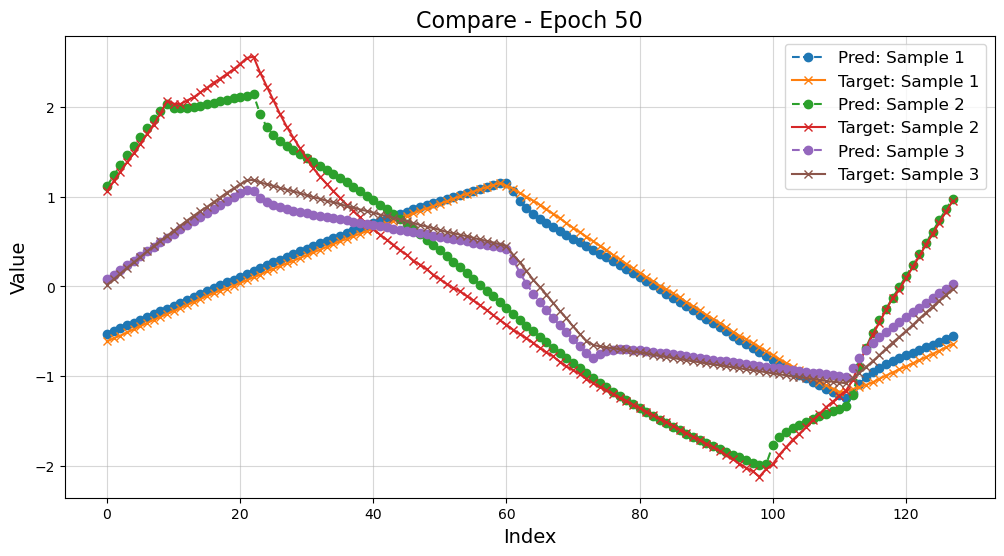

Saving model at epoch 50 with validation loss 0.016624...
Epoch 51, Train Loss: 0.015645, Validation Loss: 0.016477
Saving model at epoch 51 with validation loss 0.016477...
Epoch 52, Train Loss: 0.015405, Validation Loss: 0.016308
Saving model at epoch 52 with validation loss 0.016308...
Epoch 53, Train Loss: 0.015241, Validation Loss: 0.016169
Saving model at epoch 53 with validation loss 0.016169...
Epoch 54, Train Loss: 0.015170, Validation Loss: 0.016077
Saving model at epoch 54 with validation loss 0.016077...
Epoch 55, Train Loss: 0.015005, Validation Loss: 0.015936
Saving model at epoch 55 with validation loss 0.015936...
Epoch 56, Train Loss: 0.014890, Validation Loss: 0.015697
Saving model at epoch 56 with validation loss 0.015697...
Epoch 57, Train Loss: 0.014659, Validation Loss: 0.015632
Saving model at epoch 57 with validation loss 0.015632...
Epoch 58, Train Loss: 0.014590, Validation Loss: 0.015329
Saving model at epoch 58 with validation loss 0.015329...
Epoch 59, Trai

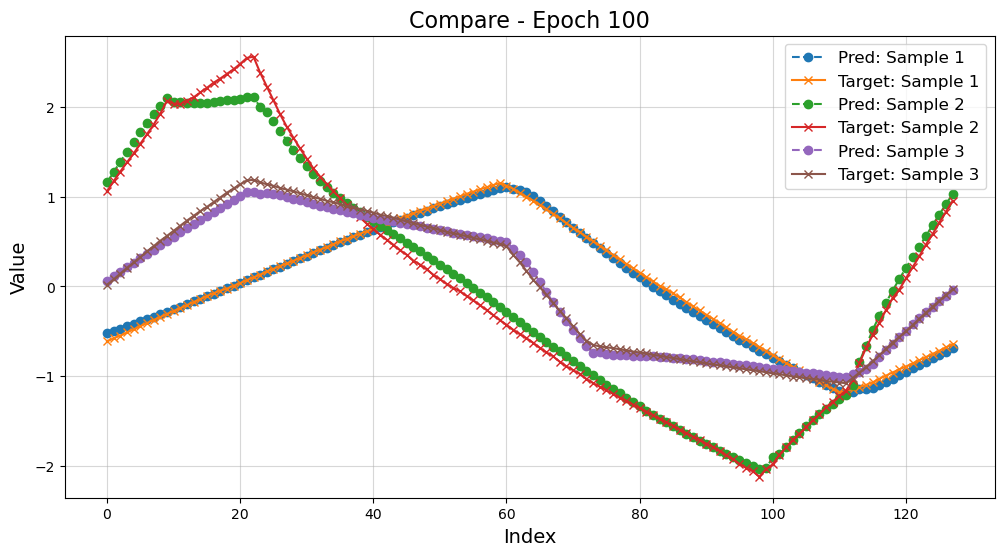

Saving model at epoch 100 with validation loss 0.006481...
Epoch 101, Train Loss: 0.006443, Validation Loss: 0.006845
Epoch 102, Train Loss: 0.006642, Validation Loss: 0.006643
Epoch 103, Train Loss: 0.006064, Validation Loss: 0.006275
Saving model at epoch 103 with validation loss 0.006275...
Epoch 104, Train Loss: 0.005994, Validation Loss: 0.006386
Epoch 105, Train Loss: 0.006034, Validation Loss: 0.006103
Saving model at epoch 105 with validation loss 0.006103...
Epoch 106, Train Loss: 0.006002, Validation Loss: 0.006005
Saving model at epoch 106 with validation loss 0.006005...
Epoch 107, Train Loss: 0.005850, Validation Loss: 0.006012
Epoch 108, Train Loss: 0.006080, Validation Loss: 0.006266
Epoch 109, Train Loss: 0.005979, Validation Loss: 0.006276
Epoch 110, Train Loss: 0.005839, Validation Loss: 0.006854
Epoch 111, Train Loss: 0.005912, Validation Loss: 0.006334
Epoch 112, Train Loss: 0.006597, Validation Loss: 0.006472
Epoch 113, Train Loss: 0.006235, Validation Loss: 0.0060

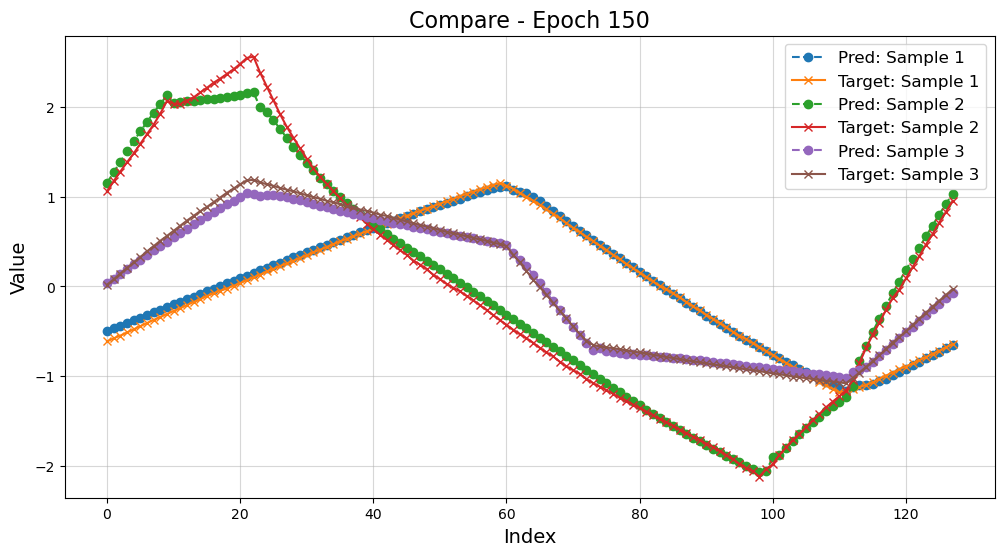

Epoch 151, Train Loss: 0.005267, Validation Loss: 0.005126
Epoch 152, Train Loss: 0.005133, Validation Loss: 0.005139
Epoch 153, Train Loss: 0.005071, Validation Loss: 0.005016
Saving model at epoch 153 with validation loss 0.005016...
Epoch 154, Train Loss: 0.005351, Validation Loss: 0.004991
Saving model at epoch 154 with validation loss 0.004991...
Epoch 155, Train Loss: 0.005411, Validation Loss: 0.006174
Epoch 156, Train Loss: 0.005189, Validation Loss: 0.005167
Epoch 157, Train Loss: 0.005099, Validation Loss: 0.005183
Epoch 158, Train Loss: 0.005200, Validation Loss: 0.005230
Epoch 159, Train Loss: 0.005166, Validation Loss: 0.005473
Epoch 160, Train Loss: 0.005137, Validation Loss: 0.005025
Epoch 161, Train Loss: 0.004993, Validation Loss: 0.005089
Epoch 162, Train Loss: 0.004934, Validation Loss: 0.005398
Epoch 163, Train Loss: 0.005072, Validation Loss: 0.005200
Epoch 164, Train Loss: 0.004968, Validation Loss: 0.005047
Epoch 165, Train Loss: 0.005091, Validation Loss: 0.0053

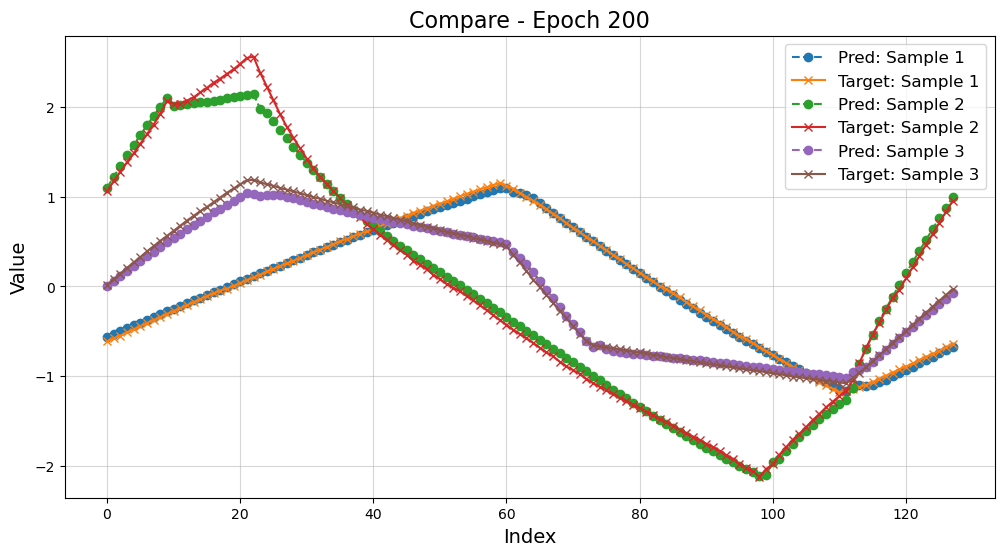

Saving model at epoch 200 with validation loss 0.004610...
Epoch 201, Train Loss: 0.004567, Validation Loss: 0.004848
Epoch 202, Train Loss: 0.004846, Validation Loss: 0.005005
Epoch 203, Train Loss: 0.004559, Validation Loss: 0.004677
Epoch 204, Train Loss: 0.004593, Validation Loss: 0.004598
Saving model at epoch 204 with validation loss 0.004598...
Epoch 205, Train Loss: 0.004535, Validation Loss: 0.004801
Epoch 206, Train Loss: 0.004652, Validation Loss: 0.005634
Epoch 207, Train Loss: 0.004820, Validation Loss: 0.004748
Epoch 208, Train Loss: 0.004820, Validation Loss: 0.004637
Epoch 209, Train Loss: 0.004677, Validation Loss: 0.004704
Epoch 210, Train Loss: 0.004735, Validation Loss: 0.004562
Saving model at epoch 210 with validation loss 0.004562...
Epoch 211, Train Loss: 0.004506, Validation Loss: 0.004597
Epoch 212, Train Loss: 0.004575, Validation Loss: 0.004712
Epoch 213, Train Loss: 0.004469, Validation Loss: 0.004771
Epoch 214, Train Loss: 0.004587, Validation Loss: 0.0047

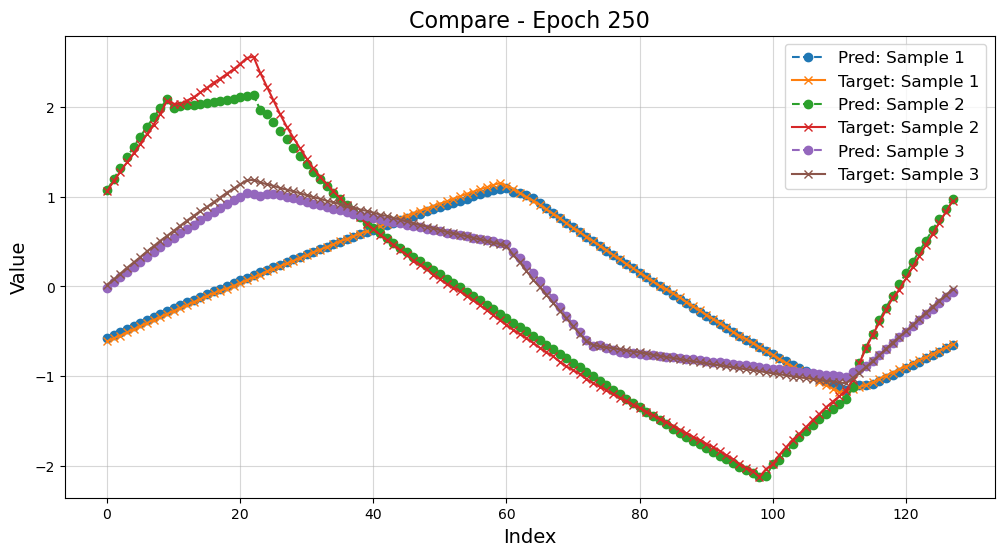

Epoch 251, Train Loss: 0.004312, Validation Loss: 0.004450
Epoch 252, Train Loss: 0.004276, Validation Loss: 0.004382
Saving model at epoch 252 with validation loss 0.004382...
Epoch 253, Train Loss: 0.004286, Validation Loss: 0.004670
Epoch 254, Train Loss: 0.004456, Validation Loss: 0.005076
Epoch 255, Train Loss: 0.004584, Validation Loss: 0.004563
Epoch 256, Train Loss: 0.004416, Validation Loss: 0.004745
Epoch 257, Train Loss: 0.004504, Validation Loss: 0.004330
Saving model at epoch 257 with validation loss 0.004330...
Epoch 258, Train Loss: 0.004254, Validation Loss: 0.004550
Epoch 259, Train Loss: 0.004405, Validation Loss: 0.005082
Epoch 260, Train Loss: 0.004357, Validation Loss: 0.004395
Epoch 261, Train Loss: 0.004267, Validation Loss: 0.004433
Epoch 262, Train Loss: 0.004400, Validation Loss: 0.004379
Epoch 263, Train Loss: 0.004413, Validation Loss: 0.004512
Epoch 264, Train Loss: 0.004410, Validation Loss: 0.004507
Epoch 265, Train Loss: 0.004337, Validation Loss: 0.0051

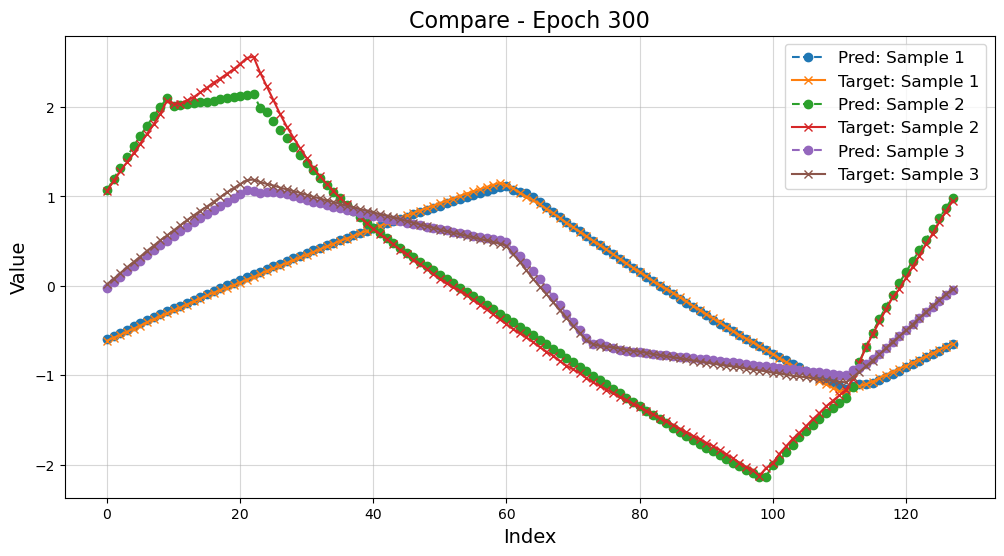

Saving model at epoch 300 with validation loss 0.004269...
Epoch 301, Train Loss: 0.004286, Validation Loss: 0.004522
Epoch 302, Train Loss: 0.004390, Validation Loss: 0.004230
Saving model at epoch 302 with validation loss 0.004230...
Epoch 303, Train Loss: 0.004183, Validation Loss: 0.004205
Saving model at epoch 303 with validation loss 0.004205...
Epoch 304, Train Loss: 0.004094, Validation Loss: 0.004207
Epoch 305, Train Loss: 0.004134, Validation Loss: 0.004195
Saving model at epoch 305 with validation loss 0.004195...
Epoch 306, Train Loss: 0.004170, Validation Loss: 0.004226
Epoch 307, Train Loss: 0.004367, Validation Loss: 0.004709
Epoch 308, Train Loss: 0.004748, Validation Loss: 0.004299
Epoch 309, Train Loss: 0.004535, Validation Loss: 0.004920
Epoch 310, Train Loss: 0.004244, Validation Loss: 0.004778
Epoch 311, Train Loss: 0.004285, Validation Loss: 0.004645
Epoch 312, Train Loss: 0.004231, Validation Loss: 0.004238
Epoch 313, Train Loss: 0.004401, Validation Loss: 0.0044

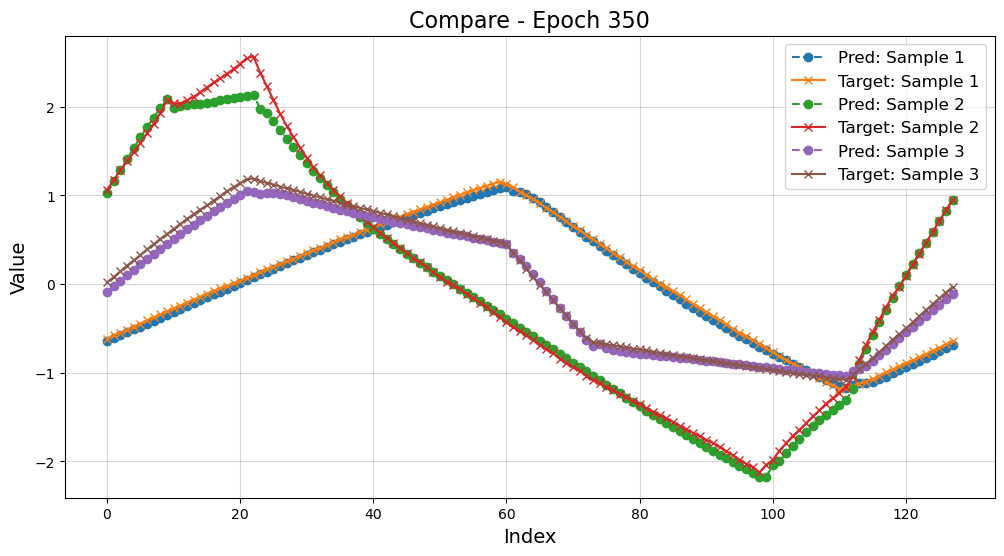

Epoch 351, Train Loss: 0.004177, Validation Loss: 0.004672
Epoch 352, Train Loss: 0.004296, Validation Loss: 0.004169
Epoch 353, Train Loss: 0.004038, Validation Loss: 0.004161
Epoch 354, Train Loss: 0.004032, Validation Loss: 0.004321
Epoch 355, Train Loss: 0.004070, Validation Loss: 0.004601
Epoch 356, Train Loss: 0.003963, Validation Loss: 0.004317
Epoch 357, Train Loss: 0.004049, Validation Loss: 0.004182
Epoch 358, Train Loss: 0.004052, Validation Loss: 0.004413
Epoch 359, Train Loss: 0.004046, Validation Loss: 0.004095
Epoch 360, Train Loss: 0.004110, Validation Loss: 0.004436
Epoch 361, Train Loss: 0.004194, Validation Loss: 0.004055
Saving model at epoch 361 with validation loss 0.004055...
Epoch 362, Train Loss: 0.004148, Validation Loss: 0.004431
Epoch 363, Train Loss: 0.004195, Validation Loss: 0.004122
Epoch 364, Train Loss: 0.003987, Validation Loss: 0.004281
Epoch 365, Train Loss: 0.004114, Validation Loss: 0.004215
Epoch 366, Train Loss: 0.004032, Validation Loss: 0.0040

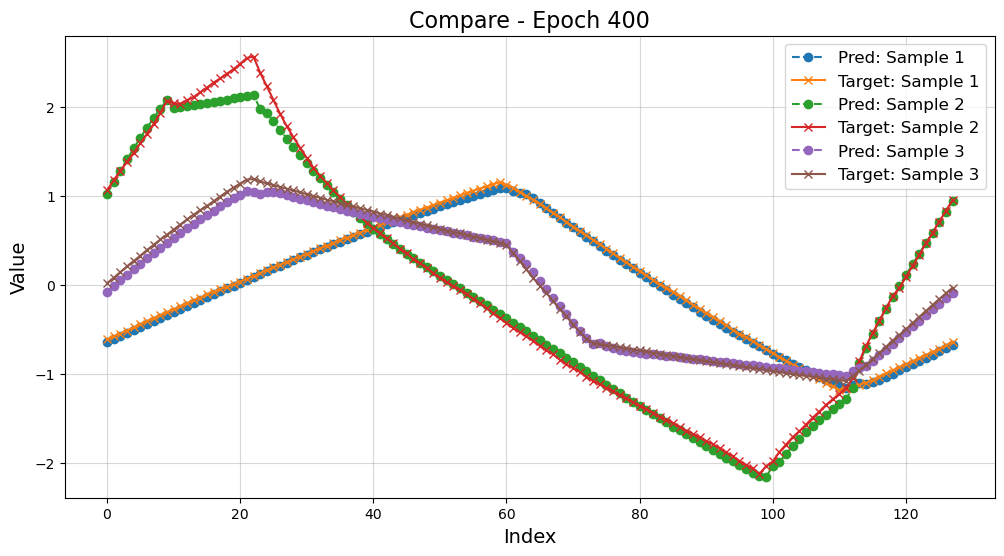

Epoch 401, Train Loss: 0.003845, Validation Loss: 0.004065
Epoch 402, Train Loss: 0.003870, Validation Loss: 0.003966
Saving model at epoch 402 with validation loss 0.003966...
Epoch 403, Train Loss: 0.003949, Validation Loss: 0.004132
Epoch 404, Train Loss: 0.004008, Validation Loss: 0.004178
Epoch 405, Train Loss: 0.004427, Validation Loss: 0.004197
Epoch 406, Train Loss: 0.004304, Validation Loss: 0.004077
Epoch 407, Train Loss: 0.004055, Validation Loss: 0.004011
Epoch 408, Train Loss: 0.004038, Validation Loss: 0.004337
Epoch 409, Train Loss: 0.004248, Validation Loss: 0.003998
Epoch 410, Train Loss: 0.003896, Validation Loss: 0.003973
Epoch 411, Train Loss: 0.003773, Validation Loss: 0.003948
Saving model at epoch 411 with validation loss 0.003948...
Epoch 412, Train Loss: 0.003910, Validation Loss: 0.004352
Epoch 413, Train Loss: 0.003848, Validation Loss: 0.003984
Epoch 414, Train Loss: 0.003794, Validation Loss: 0.003936
Saving model at epoch 414 with validation loss 0.003936.

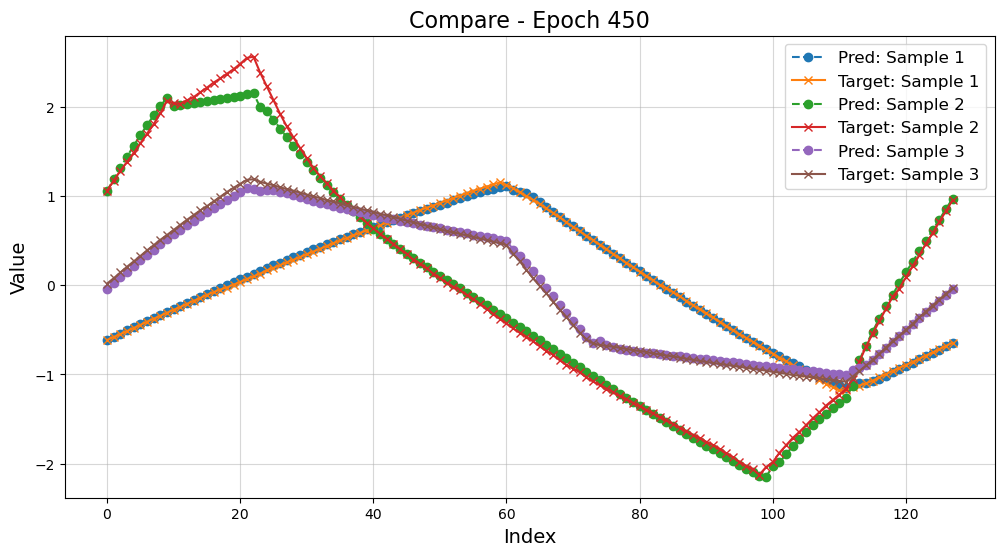

Epoch 451, Train Loss: 0.003869, Validation Loss: 0.003988
Epoch 452, Train Loss: 0.003828, Validation Loss: 0.003999
Epoch 453, Train Loss: 0.003787, Validation Loss: 0.003933
Epoch 454, Train Loss: 0.003773, Validation Loss: 0.004149
Epoch 455, Train Loss: 0.003968, Validation Loss: 0.003849
Saving model at epoch 455 with validation loss 0.003849...
Epoch 456, Train Loss: 0.003794, Validation Loss: 0.003973
Epoch 457, Train Loss: 0.003734, Validation Loss: 0.003866
Epoch 458, Train Loss: 0.003725, Validation Loss: 0.004133
Epoch 459, Train Loss: 0.003836, Validation Loss: 0.004144
Epoch 460, Train Loss: 0.003896, Validation Loss: 0.004010
Epoch 461, Train Loss: 0.003779, Validation Loss: 0.003970
Epoch 462, Train Loss: 0.003749, Validation Loss: 0.003900
Epoch 463, Train Loss: 0.003802, Validation Loss: 0.004283
Epoch 464, Train Loss: 0.003798, Validation Loss: 0.003818
Saving model at epoch 464 with validation loss 0.003818...
Epoch 465, Train Loss: 0.003677, Validation Loss: 0.0039

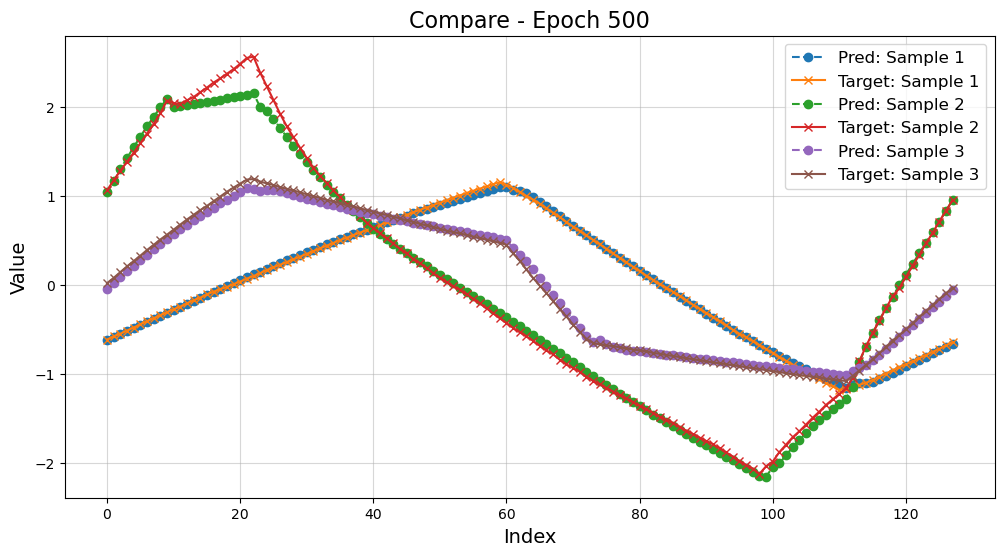

Epoch 501, Train Loss: 0.003693, Validation Loss: 0.003909
Epoch 502, Train Loss: 0.003738, Validation Loss: 0.003890
Epoch 503, Train Loss: 0.003707, Validation Loss: 0.003774
Epoch 504, Train Loss: 0.003747, Validation Loss: 0.003899
Epoch 505, Train Loss: 0.003886, Validation Loss: 0.003810
Epoch 506, Train Loss: 0.003661, Validation Loss: 0.003904
Epoch 507, Train Loss: 0.003682, Validation Loss: 0.004083
Epoch 508, Train Loss: 0.003669, Validation Loss: 0.003783
Epoch 509, Train Loss: 0.003640, Validation Loss: 0.003862
Epoch 510, Train Loss: 0.003680, Validation Loss: 0.003863
Epoch 511, Train Loss: 0.003748, Validation Loss: 0.003949
Epoch 512, Train Loss: 0.003730, Validation Loss: 0.003747
Saving model at epoch 512 with validation loss 0.003747...
Epoch 513, Train Loss: 0.003700, Validation Loss: 0.003810
Epoch 514, Train Loss: 0.003636, Validation Loss: 0.003765
Epoch 515, Train Loss: 0.003642, Validation Loss: 0.003899
Epoch 516, Train Loss: 0.003657, Validation Loss: 0.0036

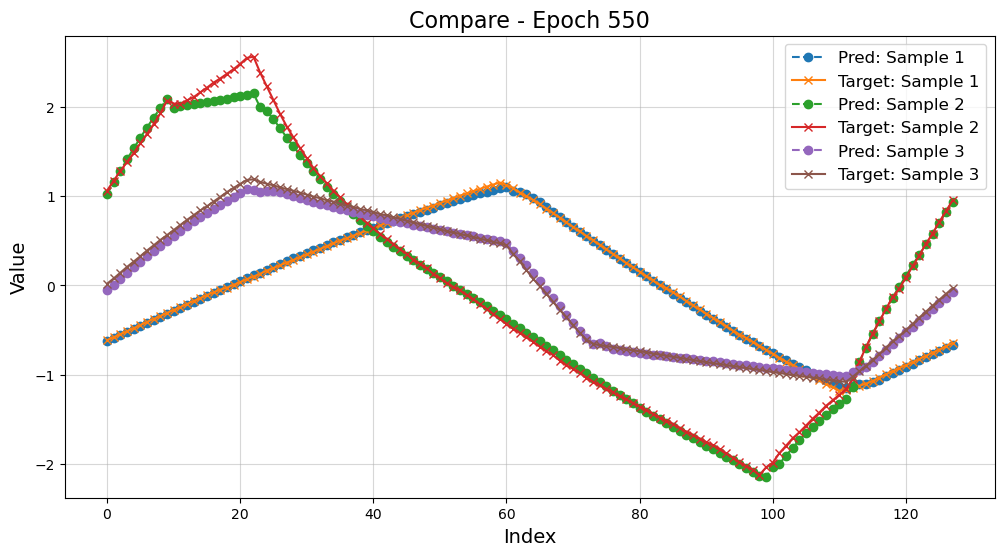

Saving model at epoch 550 with validation loss 0.003656...
Epoch 551, Train Loss: 0.003588, Validation Loss: 0.003834
Epoch 552, Train Loss: 0.003624, Validation Loss: 0.003781
Epoch 553, Train Loss: 0.003545, Validation Loss: 0.003641
Saving model at epoch 553 with validation loss 0.003641...
Epoch 554, Train Loss: 0.003688, Validation Loss: 0.004249
Epoch 555, Train Loss: 0.003762, Validation Loss: 0.004048
Epoch 556, Train Loss: 0.003620, Validation Loss: 0.003624
Saving model at epoch 556 with validation loss 0.003624...
Epoch 557, Train Loss: 0.003595, Validation Loss: 0.003726
Epoch 558, Train Loss: 0.003680, Validation Loss: 0.003985
Epoch 559, Train Loss: 0.003722, Validation Loss: 0.003861
Epoch 560, Train Loss: 0.003636, Validation Loss: 0.003824
Epoch 561, Train Loss: 0.003658, Validation Loss: 0.003764
Epoch 562, Train Loss: 0.003872, Validation Loss: 0.003696
Epoch 563, Train Loss: 0.003698, Validation Loss: 0.003682
Epoch 564, Train Loss: 0.003686, Validation Loss: 0.0044

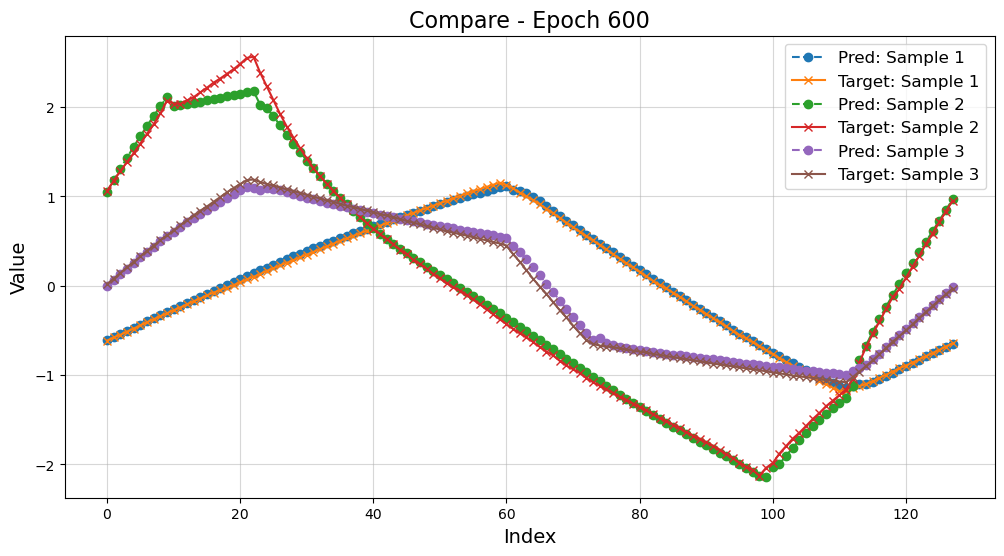

Epoch 601, Train Loss: 0.003535, Validation Loss: 0.003641
Epoch 602, Train Loss: 0.003580, Validation Loss: 0.003869
Epoch 603, Train Loss: 0.003667, Validation Loss: 0.004121
Epoch 604, Train Loss: 0.003583, Validation Loss: 0.003653
Epoch 605, Train Loss: 0.003609, Validation Loss: 0.003611
Epoch 606, Train Loss: 0.003566, Validation Loss: 0.003617
Epoch 607, Train Loss: 0.003547, Validation Loss: 0.003670
Epoch 608, Train Loss: 0.003557, Validation Loss: 0.004081
Epoch 609, Train Loss: 0.003753, Validation Loss: 0.004768
Epoch 610, Train Loss: 0.003937, Validation Loss: 0.003597
Epoch 611, Train Loss: 0.003595, Validation Loss: 0.003580
Epoch 612, Train Loss: 0.003614, Validation Loss: 0.003899
Epoch 613, Train Loss: 0.003750, Validation Loss: 0.004457
Epoch 614, Train Loss: 0.003774, Validation Loss: 0.004238
Epoch 615, Train Loss: 0.003677, Validation Loss: 0.003797
Epoch 616, Train Loss: 0.003683, Validation Loss: 0.003674
Epoch 617, Train Loss: 0.003531, Validation Loss: 0.0038

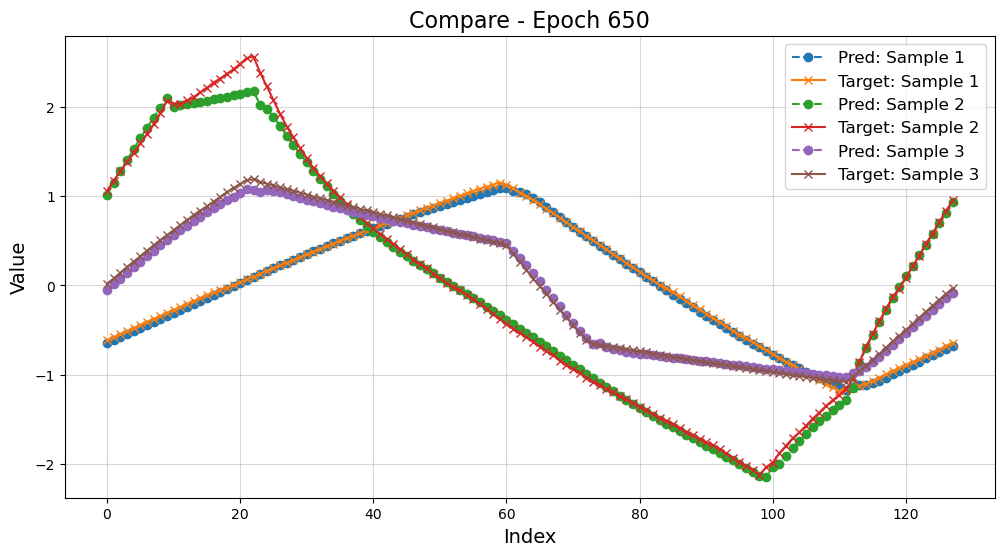

Epoch 651, Train Loss: 0.003821, Validation Loss: 0.003510
Epoch 652, Train Loss: 0.003805, Validation Loss: 0.003596
Epoch 653, Train Loss: 0.003590, Validation Loss: 0.003550
Epoch 654, Train Loss: 0.003523, Validation Loss: 0.003524
Epoch 655, Train Loss: 0.003709, Validation Loss: 0.003562
Epoch 656, Train Loss: 0.003528, Validation Loss: 0.003601
Epoch 657, Train Loss: 0.003513, Validation Loss: 0.003527
Epoch 658, Train Loss: 0.003448, Validation Loss: 0.003485
Saving model at epoch 658 with validation loss 0.003485...
Epoch 659, Train Loss: 0.003695, Validation Loss: 0.003501
Epoch 660, Train Loss: 0.003487, Validation Loss: 0.003605
Epoch 661, Train Loss: 0.003547, Validation Loss: 0.003542
Epoch 662, Train Loss: 0.003447, Validation Loss: 0.003513
Epoch 663, Train Loss: 0.003391, Validation Loss: 0.003593
Epoch 664, Train Loss: 0.003488, Validation Loss: 0.003593
Epoch 665, Train Loss: 0.003531, Validation Loss: 0.003521
Epoch 666, Train Loss: 0.003459, Validation Loss: 0.0035

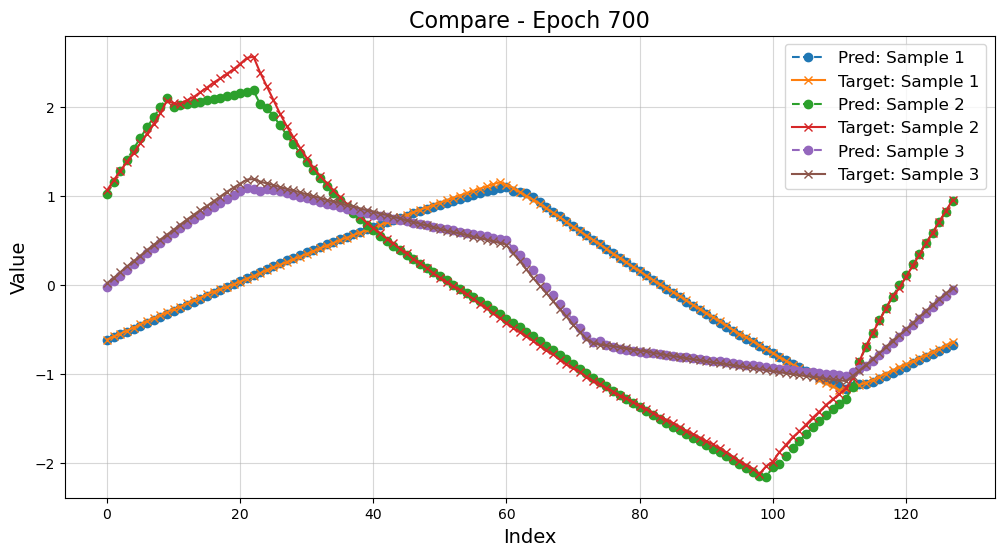

Epoch 701, Train Loss: 0.003322, Validation Loss: 0.003437
Saving model at epoch 701 with validation loss 0.003437...
Epoch 702, Train Loss: 0.003328, Validation Loss: 0.003473
Epoch 703, Train Loss: 0.003364, Validation Loss: 0.003455
Epoch 704, Train Loss: 0.003385, Validation Loss: 0.003625
Epoch 705, Train Loss: 0.003463, Validation Loss: 0.003731
Epoch 706, Train Loss: 0.003388, Validation Loss: 0.003416
Saving model at epoch 706 with validation loss 0.003416...
Epoch 707, Train Loss: 0.003481, Validation Loss: 0.004260
Epoch 708, Train Loss: 0.003706, Validation Loss: 0.003545
Epoch 709, Train Loss: 0.003398, Validation Loss: 0.003431
Epoch 710, Train Loss: 0.003407, Validation Loss: 0.003508
Epoch 711, Train Loss: 0.003371, Validation Loss: 0.003541
Epoch 712, Train Loss: 0.003519, Validation Loss: 0.003452
Epoch 713, Train Loss: 0.003451, Validation Loss: 0.003457
Epoch 714, Train Loss: 0.003403, Validation Loss: 0.003541
Epoch 715, Train Loss: 0.003579, Validation Loss: 0.0035

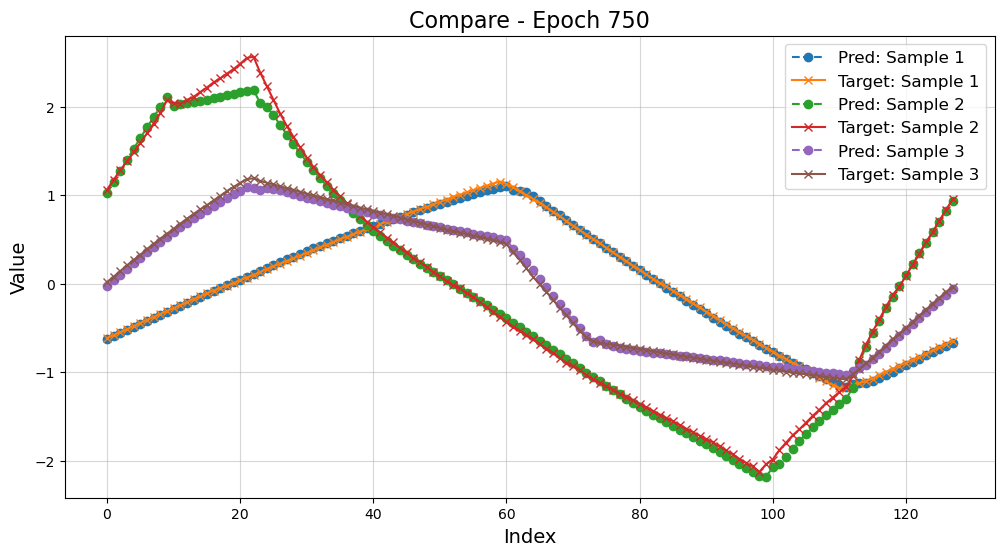

Epoch 751, Train Loss: 0.003409, Validation Loss: 0.003423
Epoch 752, Train Loss: 0.003330, Validation Loss: 0.003604
Epoch 753, Train Loss: 0.003497, Validation Loss: 0.003367
Saving model at epoch 753 with validation loss 0.003367...
Epoch 754, Train Loss: 0.003435, Validation Loss: 0.003689
Epoch 755, Train Loss: 0.003566, Validation Loss: 0.004414
Epoch 756, Train Loss: 0.003503, Validation Loss: 0.003439
Epoch 757, Train Loss: 0.003451, Validation Loss: 0.003583
Epoch 758, Train Loss: 0.003466, Validation Loss: 0.003879
Epoch 759, Train Loss: 0.003561, Validation Loss: 0.004192
Epoch 760, Train Loss: 0.003583, Validation Loss: 0.003999
Epoch 761, Train Loss: 0.003450, Validation Loss: 0.003403
Epoch 762, Train Loss: 0.003436, Validation Loss: 0.004216
Epoch 763, Train Loss: 0.003861, Validation Loss: 0.003581
Epoch 764, Train Loss: 0.003349, Validation Loss: 0.003399
Epoch 765, Train Loss: 0.003462, Validation Loss: 0.003526
Epoch 766, Train Loss: 0.003526, Validation Loss: 0.0034

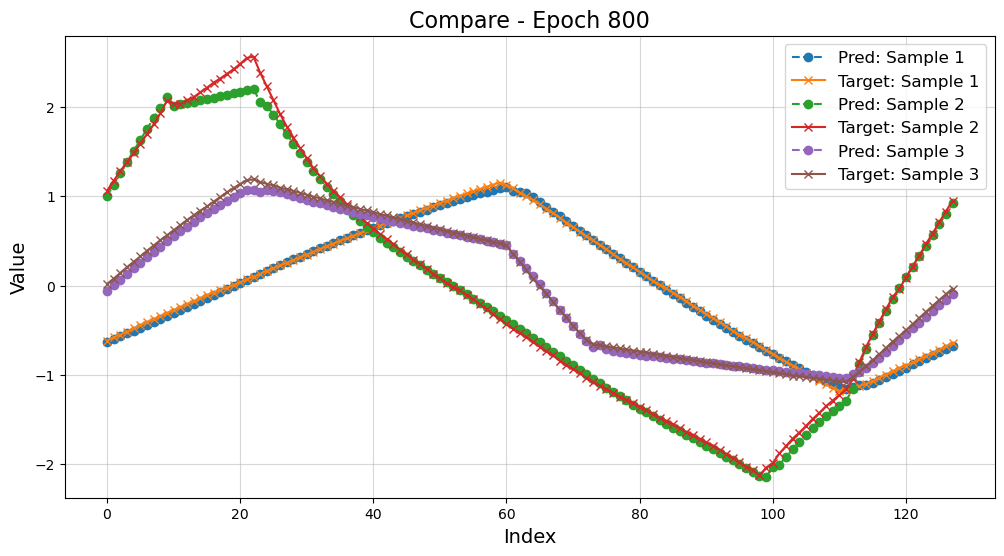

Epoch 801, Train Loss: 0.003392, Validation Loss: 0.003399
Epoch 802, Train Loss: 0.003326, Validation Loss: 0.003329
Epoch 803, Train Loss: 0.003254, Validation Loss: 0.003305
Epoch 804, Train Loss: 0.003374, Validation Loss: 0.003315
Epoch 805, Train Loss: 0.003394, Validation Loss: 0.003703
Epoch 806, Train Loss: 0.003424, Validation Loss: 0.003405
Epoch 807, Train Loss: 0.003300, Validation Loss: 0.003377
Epoch 808, Train Loss: 0.003305, Validation Loss: 0.003566
Epoch 809, Train Loss: 0.003431, Validation Loss: 0.003352
Epoch 810, Train Loss: 0.003252, Validation Loss: 0.003303
Epoch 811, Train Loss: 0.003263, Validation Loss: 0.003317
Epoch 812, Train Loss: 0.003242, Validation Loss: 0.003584
Epoch 813, Train Loss: 0.003343, Validation Loss: 0.003352
Epoch 814, Train Loss: 0.003385, Validation Loss: 0.003402
Epoch 815, Train Loss: 0.003335, Validation Loss: 0.003320
Epoch 816, Train Loss: 0.003374, Validation Loss: 0.003874
Epoch 817, Train Loss: 0.003752, Validation Loss: 0.0036

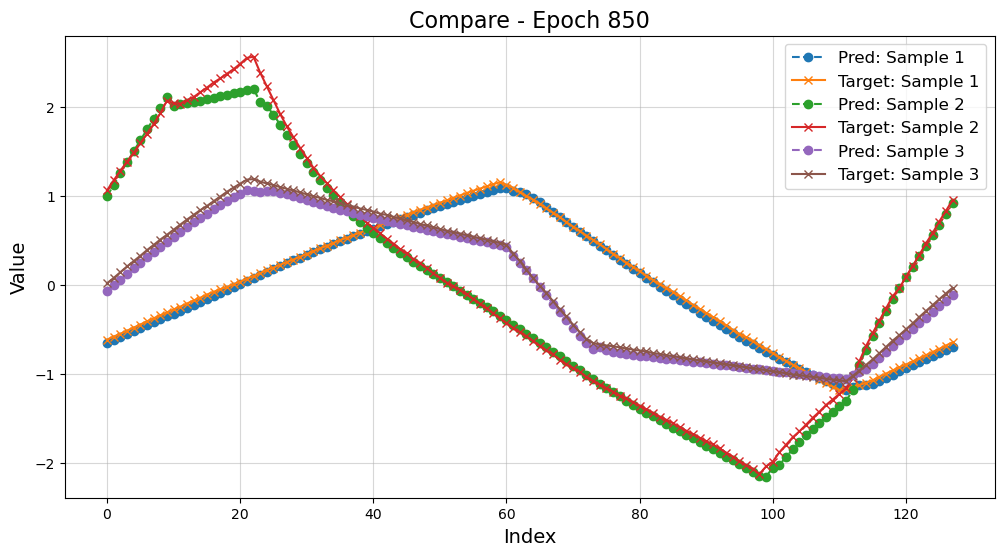

Epoch 851, Train Loss: 0.003382, Validation Loss: 0.003324
Epoch 852, Train Loss: 0.003379, Validation Loss: 0.003280
Epoch 853, Train Loss: 0.003508, Validation Loss: 0.003309
Epoch 854, Train Loss: 0.003232, Validation Loss: 0.003657
Epoch 855, Train Loss: 0.003321, Validation Loss: 0.003322
Epoch 856, Train Loss: 0.003395, Validation Loss: 0.003368
Epoch 857, Train Loss: 0.003271, Validation Loss: 0.003308
Epoch 858, Train Loss: 0.003337, Validation Loss: 0.003407
Epoch 859, Train Loss: 0.003413, Validation Loss: 0.004257
Epoch 860, Train Loss: 0.004024, Validation Loss: 0.003345
Epoch 861, Train Loss: 0.003546, Validation Loss: 0.004209
Epoch 862, Train Loss: 0.003449, Validation Loss: 0.003370
Epoch 863, Train Loss: 0.003396, Validation Loss: 0.003404
Epoch 864, Train Loss: 0.003236, Validation Loss: 0.003291
Epoch 865, Train Loss: 0.003248, Validation Loss: 0.003382
Epoch 866, Train Loss: 0.003421, Validation Loss: 0.003984
Epoch 867, Train Loss: 0.003510, Validation Loss: 0.0032

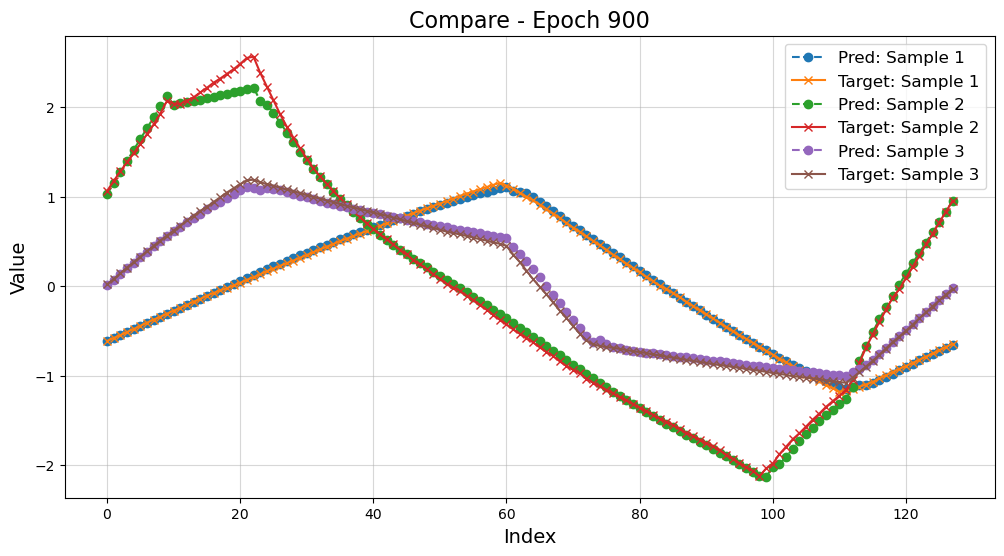

Epoch 901, Train Loss: 0.003257, Validation Loss: 0.003262
Epoch 902, Train Loss: 0.003459, Validation Loss: 0.003401
Epoch 903, Train Loss: 0.003281, Validation Loss: 0.003257
Epoch 904, Train Loss: 0.003219, Validation Loss: 0.003380
Epoch 905, Train Loss: 0.003241, Validation Loss: 0.003450
Epoch 906, Train Loss: 0.003290, Validation Loss: 0.003261
Epoch 907, Train Loss: 0.003167, Validation Loss: 0.003569
Epoch 908, Train Loss: 0.003355, Validation Loss: 0.003491
Epoch 909, Train Loss: 0.003203, Validation Loss: 0.003148
Saving model at epoch 909 with validation loss 0.003148...
Epoch 910, Train Loss: 0.003206, Validation Loss: 0.003261
Epoch 911, Train Loss: 0.003265, Validation Loss: 0.003217
Epoch 912, Train Loss: 0.003347, Validation Loss: 0.003255
Epoch 913, Train Loss: 0.003227, Validation Loss: 0.003491
Epoch 914, Train Loss: 0.003182, Validation Loss: 0.003234
Epoch 915, Train Loss: 0.003181, Validation Loss: 0.003206
Epoch 916, Train Loss: 0.003490, Validation Loss: 0.0033

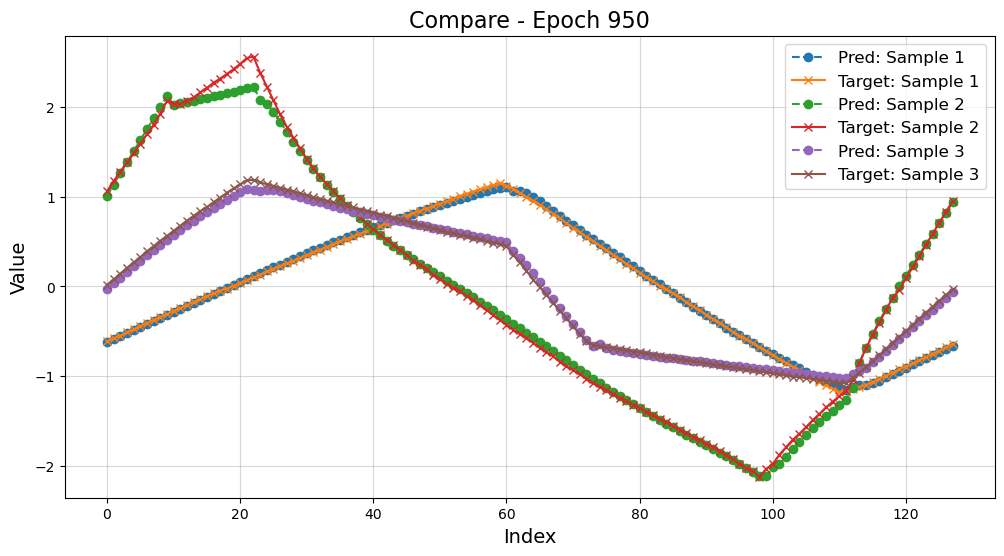

Epoch 951, Train Loss: 0.003190, Validation Loss: 0.003348
Epoch 952, Train Loss: 0.003339, Validation Loss: 0.003155
Epoch 953, Train Loss: 0.003245, Validation Loss: 0.003676
Epoch 954, Train Loss: 0.003507, Validation Loss: 0.003240
Epoch 955, Train Loss: 0.003304, Validation Loss: 0.003218
Epoch 956, Train Loss: 0.003396, Validation Loss: 0.003257
Epoch 957, Train Loss: 0.003493, Validation Loss: 0.003858
Epoch 958, Train Loss: 0.003389, Validation Loss: 0.003226
Epoch 959, Train Loss: 0.003284, Validation Loss: 0.003142
Saving model at epoch 959 with validation loss 0.003142...
Epoch 960, Train Loss: 0.003150, Validation Loss: 0.003254
Epoch 961, Train Loss: 0.003149, Validation Loss: 0.003169
Epoch 962, Train Loss: 0.003080, Validation Loss: 0.003139
Saving model at epoch 962 with validation loss 0.003139...
Epoch 963, Train Loss: 0.003100, Validation Loss: 0.003195
Epoch 964, Train Loss: 0.003216, Validation Loss: 0.003332
Epoch 965, Train Loss: 0.003267, Validation Loss: 0.0032

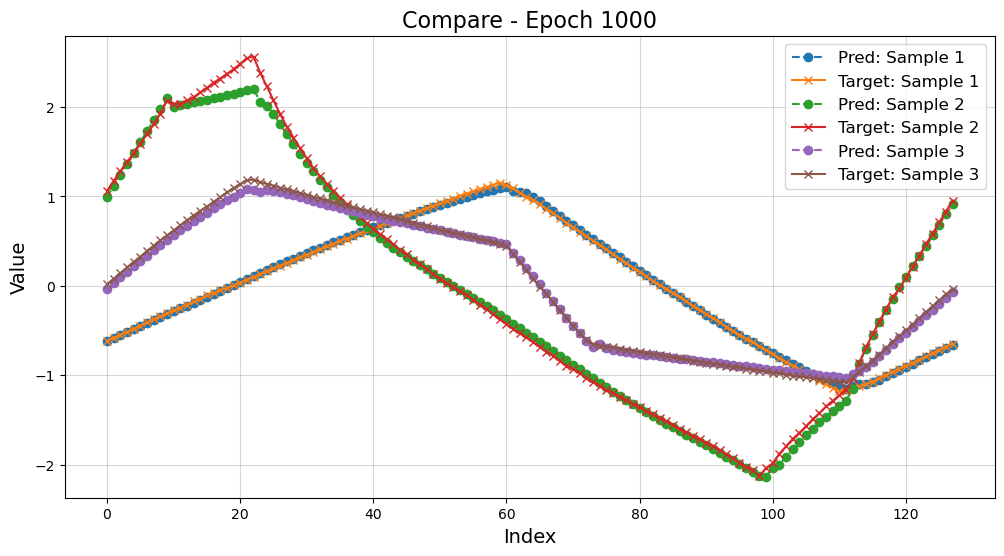

Epoch 1001, Train Loss: 0.003190, Validation Loss: 0.003138
Epoch 1002, Train Loss: 0.003108, Validation Loss: 0.003111
Saving model at epoch 1002 with validation loss 0.003111...
Epoch 1003, Train Loss: 0.003183, Validation Loss: 0.003338
Epoch 1004, Train Loss: 0.003239, Validation Loss: 0.003152
Epoch 1005, Train Loss: 0.003139, Validation Loss: 0.003181
Epoch 1006, Train Loss: 0.003137, Validation Loss: 0.003178
Epoch 1007, Train Loss: 0.003109, Validation Loss: 0.003278
Epoch 1008, Train Loss: 0.003355, Validation Loss: 0.003156
Epoch 1009, Train Loss: 0.003740, Validation Loss: 0.003268
Epoch 1010, Train Loss: 0.003850, Validation Loss: 0.003583
Epoch 1011, Train Loss: 0.003530, Validation Loss: 0.003484
Epoch 1012, Train Loss: 0.003285, Validation Loss: 0.003191
Epoch 1013, Train Loss: 0.003227, Validation Loss: 0.003192
Epoch 1014, Train Loss: 0.003182, Validation Loss: 0.003182
Epoch 1015, Train Loss: 0.003106, Validation Loss: 0.003112
Epoch 1016, Train Loss: 0.003085, Valida

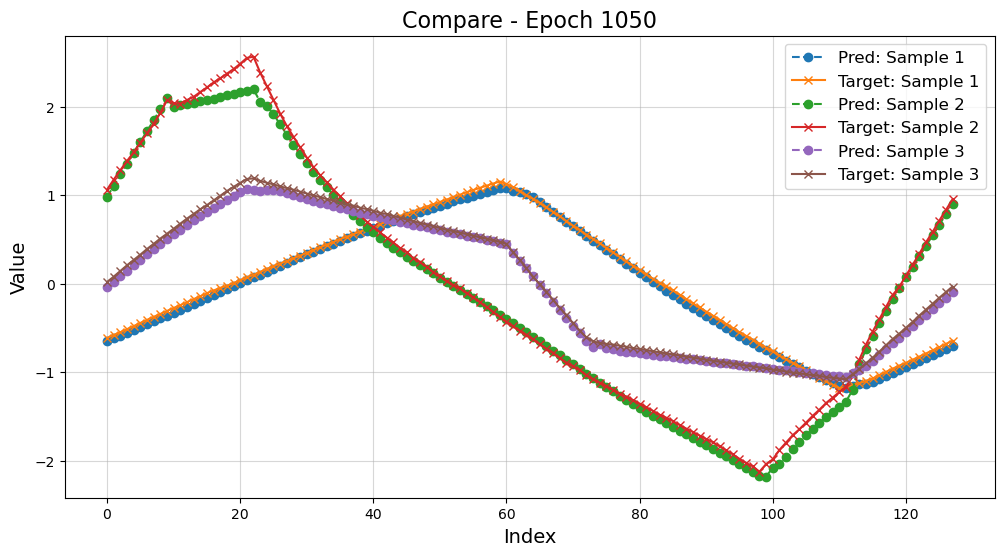

Epoch 1051, Train Loss: 0.003353, Validation Loss: 0.003553
Epoch 1052, Train Loss: 0.003263, Validation Loss: 0.003124
Epoch 1053, Train Loss: 0.003307, Validation Loss: 0.003169
Epoch 1054, Train Loss: 0.003089, Validation Loss: 0.003048
Epoch 1055, Train Loss: 0.003124, Validation Loss: 0.003313
Epoch 1056, Train Loss: 0.003401, Validation Loss: 0.003398
Epoch 1057, Train Loss: 0.003235, Validation Loss: 0.003277
Epoch 1058, Train Loss: 0.003182, Validation Loss: 0.003096
Epoch 1059, Train Loss: 0.003162, Validation Loss: 0.003244
Epoch 1060, Train Loss: 0.003163, Validation Loss: 0.003443
Epoch 1061, Train Loss: 0.003216, Validation Loss: 0.003291
Epoch 1062, Train Loss: 0.003141, Validation Loss: 0.003293
Epoch 1063, Train Loss: 0.003404, Validation Loss: 0.003244
Epoch 1064, Train Loss: 0.003227, Validation Loss: 0.003411
Epoch 1065, Train Loss: 0.003222, Validation Loss: 0.003074
Epoch 1066, Train Loss: 0.003126, Validation Loss: 0.003580
Epoch 1067, Train Loss: 0.003262, Valida

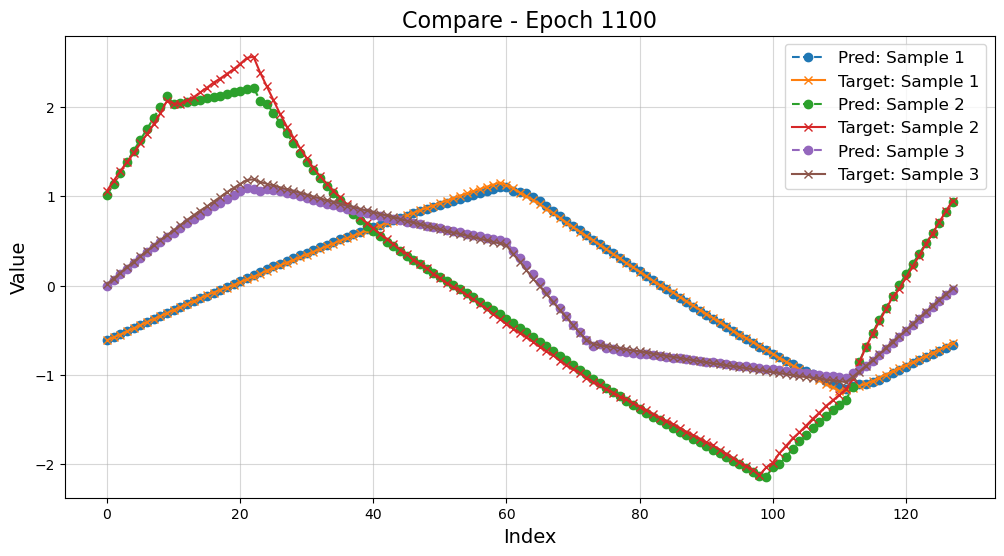

Epoch 1101, Train Loss: 0.003158, Validation Loss: 0.003340
Epoch 1102, Train Loss: 0.003303, Validation Loss: 0.003177
Epoch 1103, Train Loss: 0.003128, Validation Loss: 0.003094
Epoch 1104, Train Loss: 0.003067, Validation Loss: 0.003185
Epoch 1105, Train Loss: 0.003221, Validation Loss: 0.003437
Epoch 1106, Train Loss: 0.003183, Validation Loss: 0.003137
Epoch 1107, Train Loss: 0.003047, Validation Loss: 0.003306
Epoch 1108, Train Loss: 0.003238, Validation Loss: 0.003201
Epoch 1109, Train Loss: 0.003220, Validation Loss: 0.003401
Epoch 1110, Train Loss: 0.003153, Validation Loss: 0.003176
Epoch 1111, Train Loss: 0.003245, Validation Loss: 0.003161
Epoch 1112, Train Loss: 0.003698, Validation Loss: 0.003209
Epoch 1113, Train Loss: 0.003410, Validation Loss: 0.003335
Epoch 1114, Train Loss: 0.003293, Validation Loss: 0.003038
Saving model at epoch 1114 with validation loss 0.003038...
Epoch 1115, Train Loss: 0.003326, Validation Loss: 0.003074
Epoch 1116, Train Loss: 0.003220, Valida

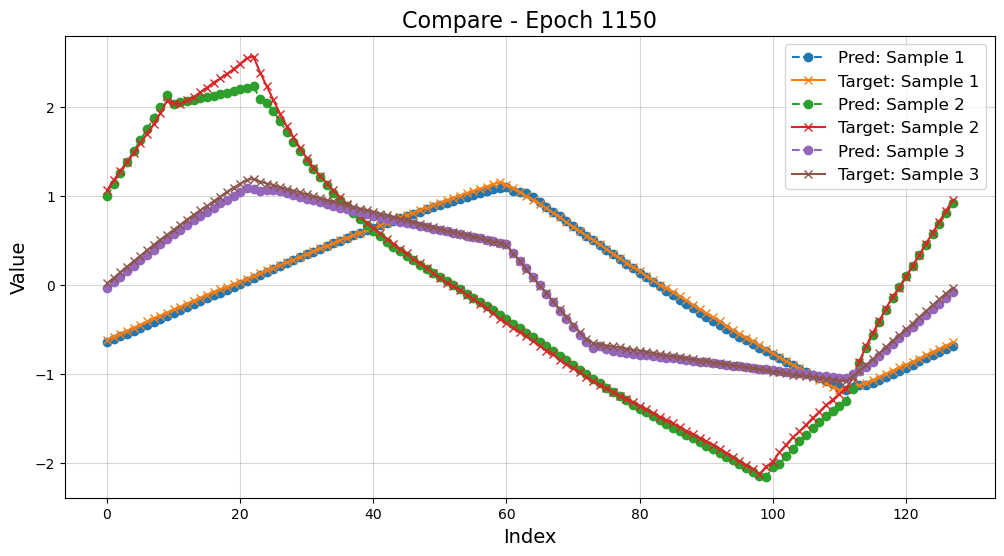

Epoch 1151, Train Loss: 0.003142, Validation Loss: 0.003103
Epoch 1152, Train Loss: 0.003274, Validation Loss: 0.003268
Epoch 1153, Train Loss: 0.003220, Validation Loss: 0.003080
Epoch 1154, Train Loss: 0.003185, Validation Loss: 0.003263
Epoch 1155, Train Loss: 0.003141, Validation Loss: 0.003254
Epoch 1156, Train Loss: 0.003230, Validation Loss: 0.002994
Saving model at epoch 1156 with validation loss 0.002994...
Epoch 1157, Train Loss: 0.003090, Validation Loss: 0.003048
Epoch 1158, Train Loss: 0.003090, Validation Loss: 0.003020
Epoch 1159, Train Loss: 0.003256, Validation Loss: 0.003167
Epoch 1160, Train Loss: 0.003533, Validation Loss: 0.003079
Epoch 1161, Train Loss: 0.003227, Validation Loss: 0.003354
Epoch 1162, Train Loss: 0.003094, Validation Loss: 0.003068
Epoch 1163, Train Loss: 0.003050, Validation Loss: 0.002990
Saving model at epoch 1163 with validation loss 0.002990...
Epoch 1164, Train Loss: 0.002993, Validation Loss: 0.003167
Epoch 1165, Train Loss: 0.003178, Valida

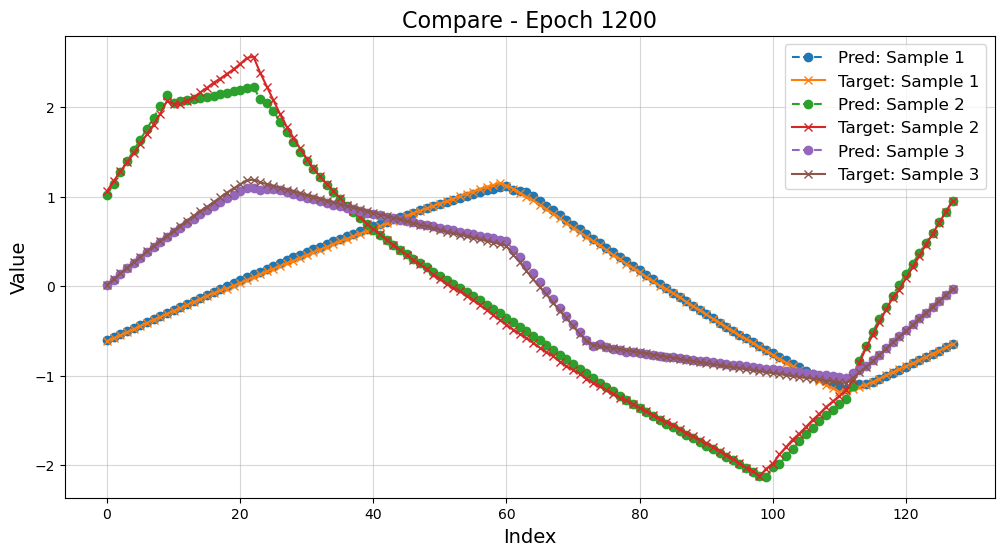

Epoch 1201, Train Loss: 0.003054, Validation Loss: 0.003196
Epoch 1202, Train Loss: 0.003187, Validation Loss: 0.003136
Epoch 1203, Train Loss: 0.003044, Validation Loss: 0.002985
Saving model at epoch 1203 with validation loss 0.002985...
Epoch 1204, Train Loss: 0.003114, Validation Loss: 0.003050
Epoch 1205, Train Loss: 0.003287, Validation Loss: 0.003050
Epoch 1206, Train Loss: 0.003313, Validation Loss: 0.003044
Epoch 1207, Train Loss: 0.003204, Validation Loss: 0.003265
Epoch 1208, Train Loss: 0.003022, Validation Loss: 0.002977
Saving model at epoch 1208 with validation loss 0.002977...
Epoch 1209, Train Loss: 0.003017, Validation Loss: 0.003009
Epoch 1210, Train Loss: 0.003063, Validation Loss: 0.003190
Epoch 1211, Train Loss: 0.003206, Validation Loss: 0.003013
Epoch 1212, Train Loss: 0.003278, Validation Loss: 0.003202
Epoch 1213, Train Loss: 0.003233, Validation Loss: 0.003123
Epoch 1214, Train Loss: 0.003041, Validation Loss: 0.003425
Epoch 1215, Train Loss: 0.003332, Valida

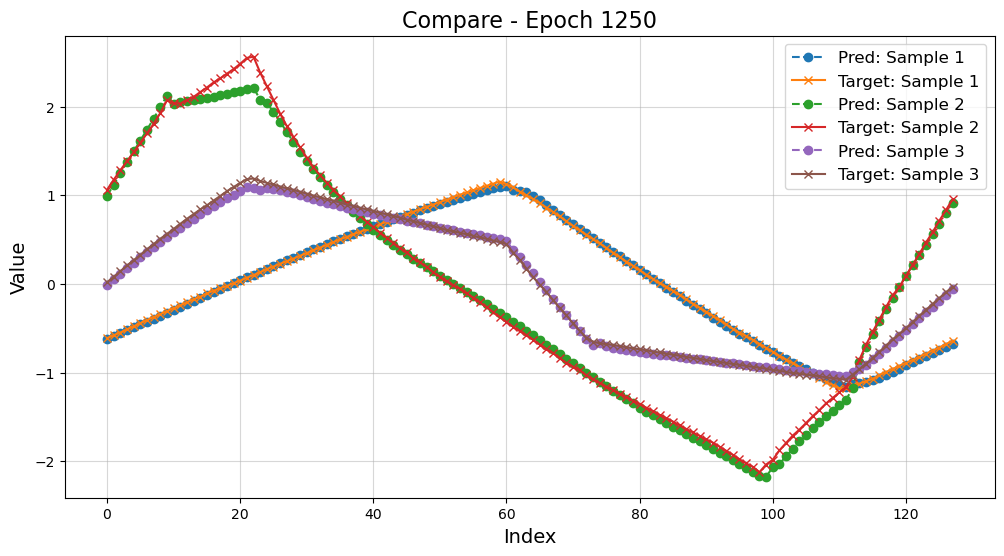

Epoch 1251, Train Loss: 0.003155, Validation Loss: 0.002991
Epoch 1252, Train Loss: 0.003030, Validation Loss: 0.003071
Epoch 1253, Train Loss: 0.003170, Validation Loss: 0.003456
Epoch 1254, Train Loss: 0.003164, Validation Loss: 0.003238
Epoch 1255, Train Loss: 0.003083, Validation Loss: 0.003040
Epoch 1256, Train Loss: 0.002989, Validation Loss: 0.003026
Epoch 1257, Train Loss: 0.002999, Validation Loss: 0.003035
Epoch 1258, Train Loss: 0.003214, Validation Loss: 0.003203
Epoch 1259, Train Loss: 0.003091, Validation Loss: 0.003105
Epoch 1260, Train Loss: 0.003060, Validation Loss: 0.003174
Epoch 1261, Train Loss: 0.003111, Validation Loss: 0.003403
Epoch 1262, Train Loss: 0.003664, Validation Loss: 0.004373
Epoch 1263, Train Loss: 0.003549, Validation Loss: 0.002975
Epoch 1264, Train Loss: 0.003223, Validation Loss: 0.003805
Epoch 1265, Train Loss: 0.003330, Validation Loss: 0.003589
Epoch 1266, Train Loss: 0.003368, Validation Loss: 0.003262
Epoch 1267, Train Loss: 0.003295, Valida

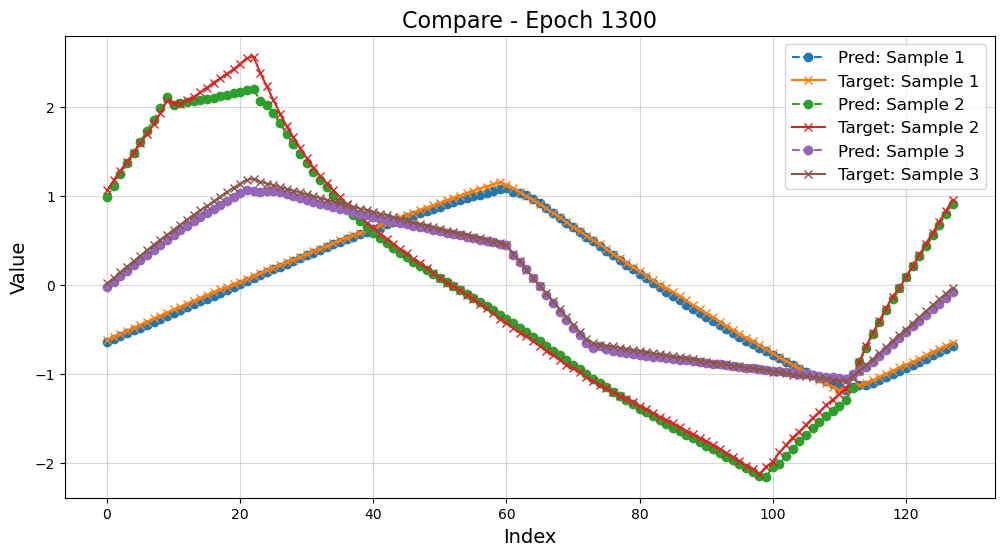

Epoch 1301, Train Loss: 0.003173, Validation Loss: 0.003350
Epoch 1302, Train Loss: 0.003036, Validation Loss: 0.003805
Epoch 1303, Train Loss: 0.003265, Validation Loss: 0.003238
Epoch 1304, Train Loss: 0.003184, Validation Loss: 0.003521
Epoch 1305, Train Loss: 0.003190, Validation Loss: 0.003686
Epoch 1306, Train Loss: 0.003284, Validation Loss: 0.003793
Epoch 1307, Train Loss: 0.003280, Validation Loss: 0.003093
Epoch 1308, Train Loss: 0.003310, Validation Loss: 0.002945
Saving model at epoch 1308 with validation loss 0.002945...
Epoch 1309, Train Loss: 0.003115, Validation Loss: 0.002975
Epoch 1310, Train Loss: 0.002983, Validation Loss: 0.003182
Epoch 1311, Train Loss: 0.003045, Validation Loss: 0.003085
Epoch 1312, Train Loss: 0.003033, Validation Loss: 0.003230
Epoch 1313, Train Loss: 0.003173, Validation Loss: 0.003266
Epoch 1314, Train Loss: 0.003127, Validation Loss: 0.003152
Epoch 1315, Train Loss: 0.003106, Validation Loss: 0.003057
Epoch 1316, Train Loss: 0.003083, Valida

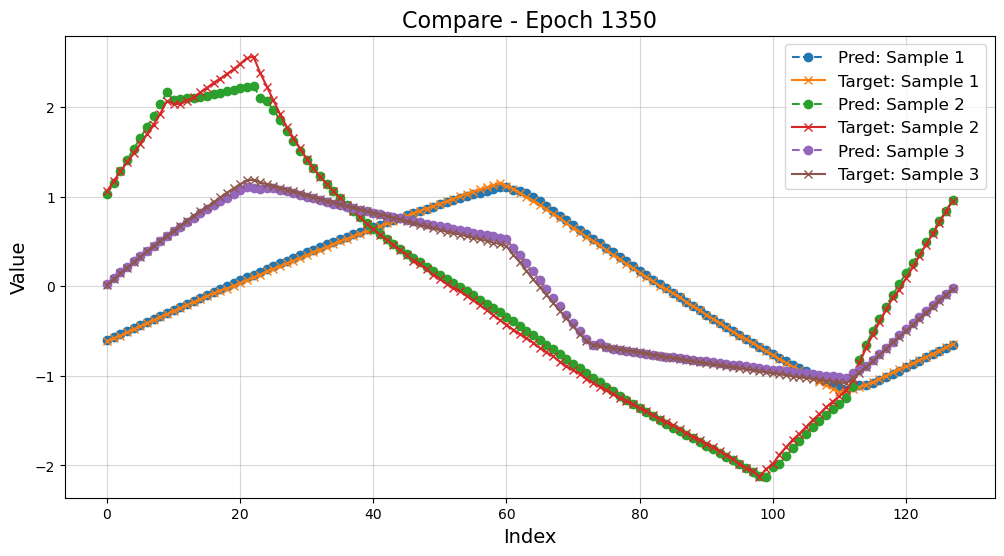

Epoch 1351, Train Loss: 0.003077, Validation Loss: 0.002941
Epoch 1352, Train Loss: 0.002981, Validation Loss: 0.002917
Saving model at epoch 1352 with validation loss 0.002917...
Epoch 1353, Train Loss: 0.003028, Validation Loss: 0.002961
Epoch 1354, Train Loss: 0.003046, Validation Loss: 0.002995
Epoch 1355, Train Loss: 0.003020, Validation Loss: 0.003030
Epoch 1356, Train Loss: 0.003321, Validation Loss: 0.003219
Epoch 1357, Train Loss: 0.003097, Validation Loss: 0.003367
Epoch 1358, Train Loss: 0.003205, Validation Loss: 0.003080
Epoch 1359, Train Loss: 0.002983, Validation Loss: 0.002947
Epoch 1360, Train Loss: 0.002972, Validation Loss: 0.003269
Epoch 1361, Train Loss: 0.003054, Validation Loss: 0.003499
Epoch 1362, Train Loss: 0.003071, Validation Loss: 0.003036
Epoch 1363, Train Loss: 0.002977, Validation Loss: 0.003002
Epoch 1364, Train Loss: 0.003080, Validation Loss: 0.002984
Epoch 1365, Train Loss: 0.003550, Validation Loss: 0.003095
Epoch 1366, Train Loss: 0.003793, Valida

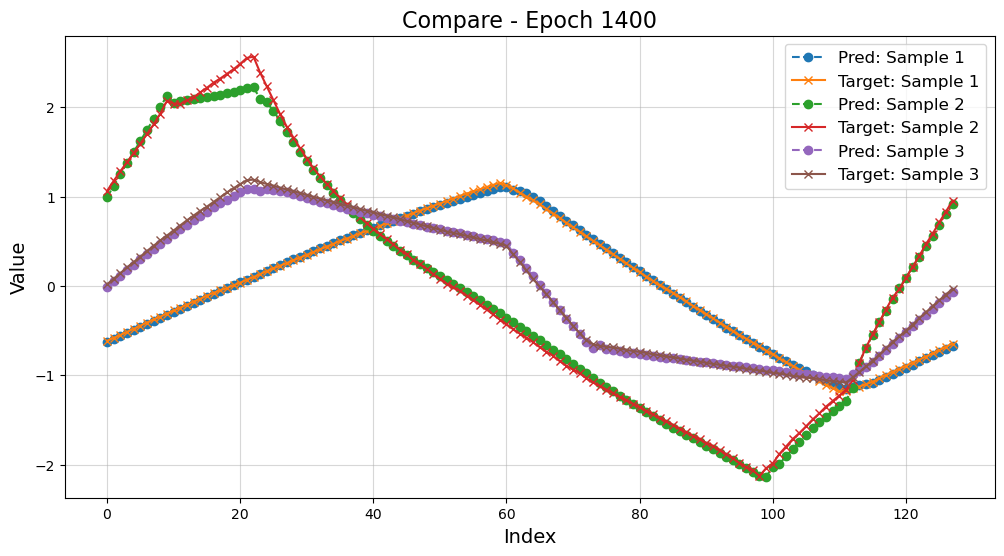

Epoch 1401, Train Loss: 0.003193, Validation Loss: 0.003040
Epoch 1402, Train Loss: 0.002969, Validation Loss: 0.003030
Epoch 1403, Train Loss: 0.002945, Validation Loss: 0.003166
Epoch 1404, Train Loss: 0.003146, Validation Loss: 0.002984
Epoch 1405, Train Loss: 0.003223, Validation Loss: 0.003110
Epoch 1406, Train Loss: 0.003049, Validation Loss: 0.003002
Epoch 1407, Train Loss: 0.003009, Validation Loss: 0.002968
Epoch 1408, Train Loss: 0.003047, Validation Loss: 0.003161
Epoch 1409, Train Loss: 0.002985, Validation Loss: 0.002919
Epoch 1410, Train Loss: 0.003041, Validation Loss: 0.002910
Saving model at epoch 1410 with validation loss 0.002910...
Epoch 1411, Train Loss: 0.003206, Validation Loss: 0.003023
Epoch 1412, Train Loss: 0.003044, Validation Loss: 0.002939
Epoch 1413, Train Loss: 0.003105, Validation Loss: 0.003831
Epoch 1414, Train Loss: 0.003126, Validation Loss: 0.003191
Epoch 1415, Train Loss: 0.003133, Validation Loss: 0.003020
Epoch 1416, Train Loss: 0.003146, Valida

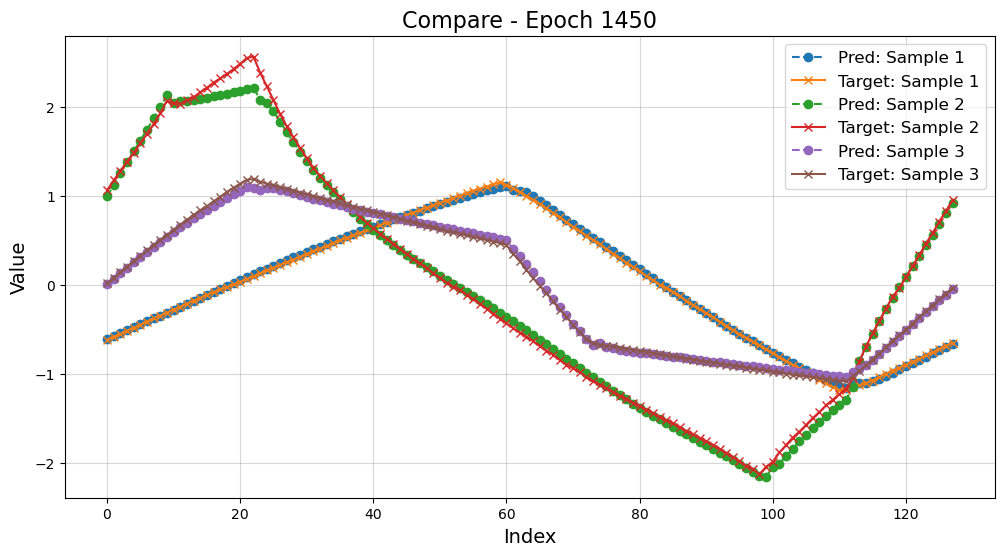

Epoch 1451, Train Loss: 0.003037, Validation Loss: 0.003230
Epoch 1452, Train Loss: 0.003115, Validation Loss: 0.002958
Epoch 1453, Train Loss: 0.003005, Validation Loss: 0.002887
Saving model at epoch 1453 with validation loss 0.002887...
Epoch 1454, Train Loss: 0.003029, Validation Loss: 0.003341
Epoch 1455, Train Loss: 0.002984, Validation Loss: 0.002921
Epoch 1456, Train Loss: 0.003004, Validation Loss: 0.003826
Epoch 1457, Train Loss: 0.003175, Validation Loss: 0.003060
Epoch 1458, Train Loss: 0.003144, Validation Loss: 0.003655
Epoch 1459, Train Loss: 0.003180, Validation Loss: 0.003015
Epoch 1460, Train Loss: 0.003071, Validation Loss: 0.003206
Epoch 1461, Train Loss: 0.003253, Validation Loss: 0.003753
Epoch 1462, Train Loss: 0.003198, Validation Loss: 0.002920
Epoch 1463, Train Loss: 0.003121, Validation Loss: 0.002910
Epoch 1464, Train Loss: 0.003016, Validation Loss: 0.002990
Epoch 1465, Train Loss: 0.003059, Validation Loss: 0.003026
Epoch 1466, Train Loss: 0.003205, Valida

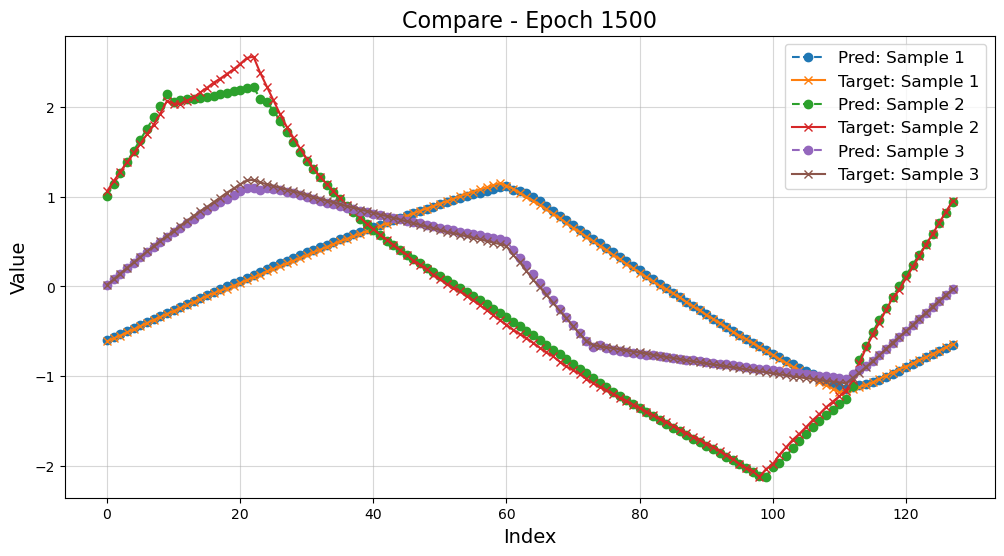

Epoch 1501, Train Loss: 0.002960, Validation Loss: 0.002901
Epoch 1502, Train Loss: 0.002903, Validation Loss: 0.002921
Epoch 1503, Train Loss: 0.003001, Validation Loss: 0.002970
Epoch 1504, Train Loss: 0.002971, Validation Loss: 0.003145
Epoch 1505, Train Loss: 0.002986, Validation Loss: 0.002951
Epoch 1506, Train Loss: 0.003074, Validation Loss: 0.003125
Epoch 1507, Train Loss: 0.002993, Validation Loss: 0.002943
Epoch 1508, Train Loss: 0.002971, Validation Loss: 0.003115
Epoch 1509, Train Loss: 0.003103, Validation Loss: 0.002958
Epoch 1510, Train Loss: 0.003002, Validation Loss: 0.002981
Epoch 1511, Train Loss: 0.003169, Validation Loss: 0.003034
Epoch 1512, Train Loss: 0.003129, Validation Loss: 0.002972
Epoch 1513, Train Loss: 0.002941, Validation Loss: 0.002989
Epoch 1514, Train Loss: 0.003045, Validation Loss: 0.002930
Epoch 1515, Train Loss: 0.002940, Validation Loss: 0.003019
Epoch 1516, Train Loss: 0.003124, Validation Loss: 0.002980
Epoch 1517, Train Loss: 0.003171, Valida

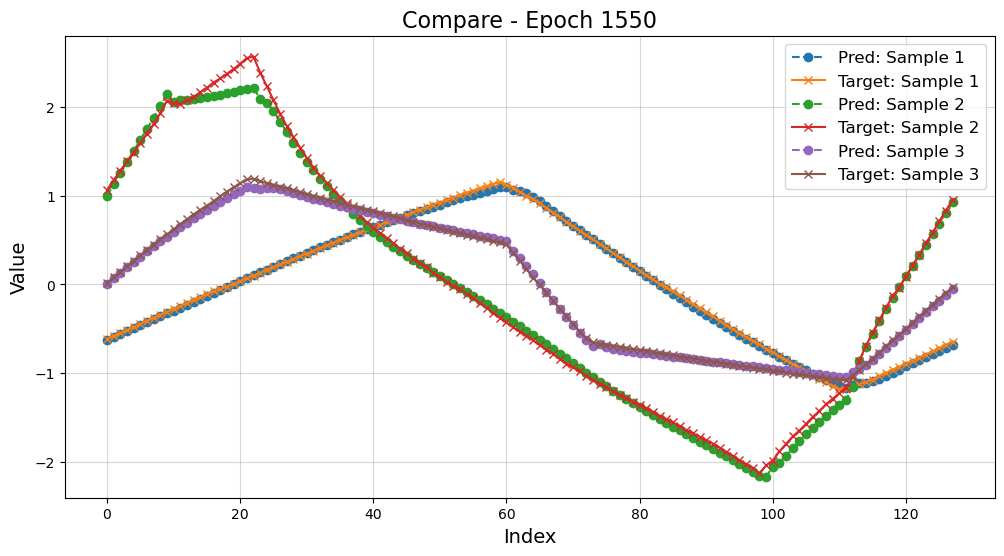

Epoch 1551, Train Loss: 0.002968, Validation Loss: 0.002905
Epoch 1552, Train Loss: 0.002983, Validation Loss: 0.002928
Epoch 1553, Train Loss: 0.002926, Validation Loss: 0.002941
Epoch 1554, Train Loss: 0.002941, Validation Loss: 0.003393
Epoch 1555, Train Loss: 0.003061, Validation Loss: 0.002906
Epoch 1556, Train Loss: 0.002965, Validation Loss: 0.002944
Epoch 1557, Train Loss: 0.002949, Validation Loss: 0.003053
Epoch 1558, Train Loss: 0.002998, Validation Loss: 0.002928
Epoch 1559, Train Loss: 0.002893, Validation Loss: 0.002929
Epoch 1560, Train Loss: 0.002852, Validation Loss: 0.003045
Epoch 1561, Train Loss: 0.003067, Validation Loss: 0.003028
Epoch 1562, Train Loss: 0.003207, Validation Loss: 0.003356
Epoch 1563, Train Loss: 0.003202, Validation Loss: 0.003062
Epoch 1564, Train Loss: 0.003199, Validation Loss: 0.002956
Epoch 1565, Train Loss: 0.002932, Validation Loss: 0.002919
Epoch 1566, Train Loss: 0.003034, Validation Loss: 0.002867
Saving model at epoch 1566 with validati

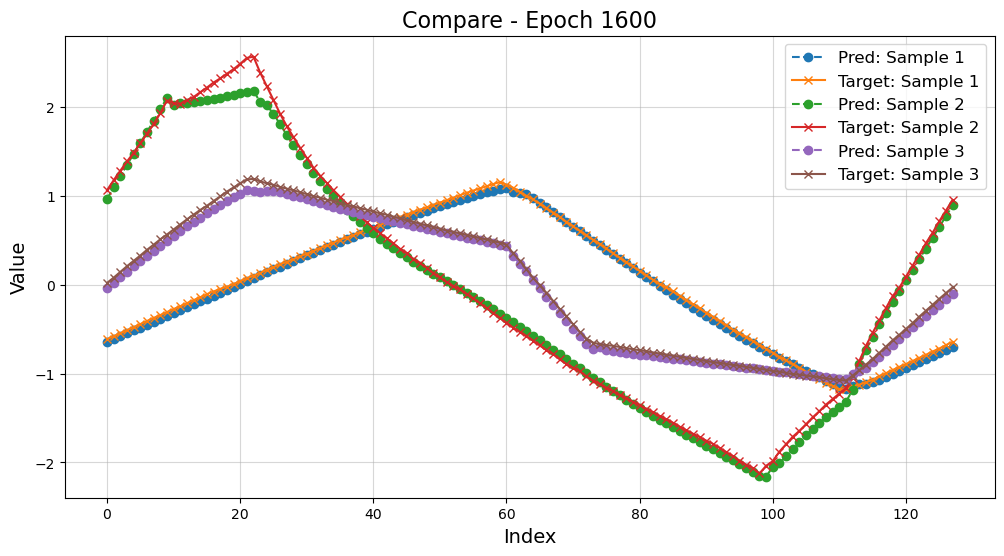

Epoch 1601, Train Loss: 0.003354, Validation Loss: 0.003364
Epoch 1602, Train Loss: 0.003120, Validation Loss: 0.003673
Epoch 1603, Train Loss: 0.003309, Validation Loss: 0.003869
Epoch 1604, Train Loss: 0.003352, Validation Loss: 0.003401
Epoch 1605, Train Loss: 0.003029, Validation Loss: 0.002875
Epoch 1606, Train Loss: 0.002911, Validation Loss: 0.002931
Epoch 1607, Train Loss: 0.002907, Validation Loss: 0.003063
Epoch 1608, Train Loss: 0.002944, Validation Loss: 0.003070
Epoch 1609, Train Loss: 0.003054, Validation Loss: 0.003048
Epoch 1610, Train Loss: 0.002932, Validation Loss: 0.003000
Epoch 1611, Train Loss: 0.003033, Validation Loss: 0.003019
Epoch 1612, Train Loss: 0.003106, Validation Loss: 0.003361
Epoch 1613, Train Loss: 0.003021, Validation Loss: 0.002902
Epoch 1614, Train Loss: 0.003032, Validation Loss: 0.003006
Epoch 1615, Train Loss: 0.002966, Validation Loss: 0.002955
Epoch 1616, Train Loss: 0.002893, Validation Loss: 0.002960
Epoch 1617, Train Loss: 0.003053, Valida

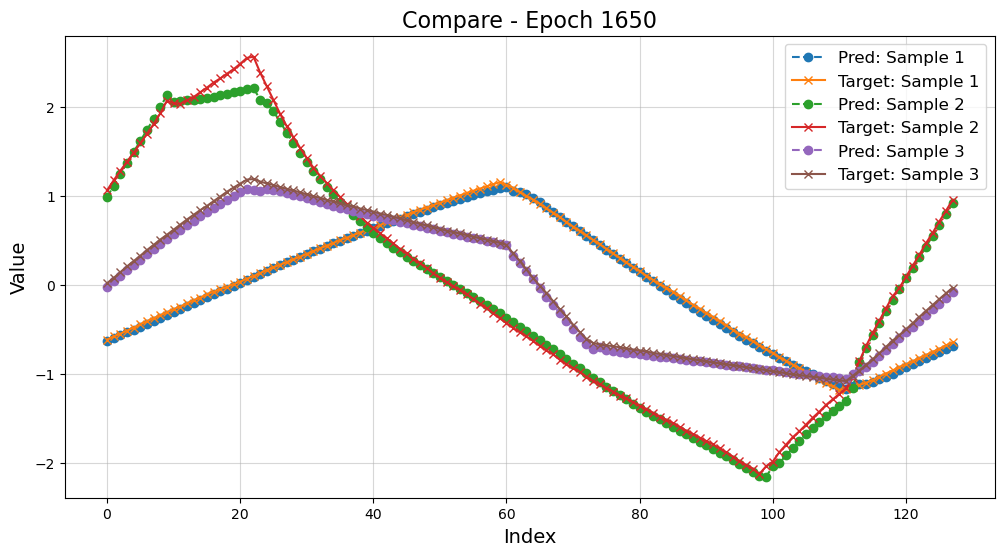

Epoch 1651, Train Loss: 0.002965, Validation Loss: 0.003172
Epoch 1652, Train Loss: 0.002951, Validation Loss: 0.003101
Epoch 1653, Train Loss: 0.002969, Validation Loss: 0.003135
Epoch 1654, Train Loss: 0.003061, Validation Loss: 0.003386
Epoch 1655, Train Loss: 0.003103, Validation Loss: 0.003321
Epoch 1656, Train Loss: 0.002964, Validation Loss: 0.003028
Epoch 1657, Train Loss: 0.003018, Validation Loss: 0.002955
Epoch 1658, Train Loss: 0.002921, Validation Loss: 0.002959
Epoch 1659, Train Loss: 0.002898, Validation Loss: 0.002882
Epoch 1660, Train Loss: 0.002904, Validation Loss: 0.002978
Epoch 1661, Train Loss: 0.002906, Validation Loss: 0.002973
Epoch 1662, Train Loss: 0.002956, Validation Loss: 0.002921
Epoch 1663, Train Loss: 0.003101, Validation Loss: 0.003104
Epoch 1664, Train Loss: 0.003238, Validation Loss: 0.003293
Epoch 1665, Train Loss: 0.002941, Validation Loss: 0.003260
Epoch 1666, Train Loss: 0.003045, Validation Loss: 0.002949
Epoch 1667, Train Loss: 0.002896, Valida

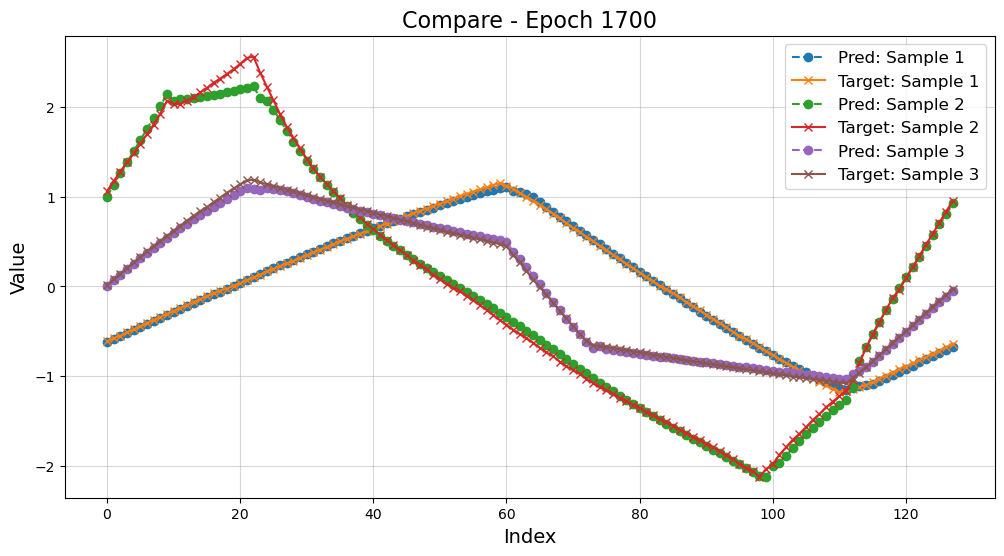

Epoch 1701, Train Loss: 0.002894, Validation Loss: 0.002937
Epoch 1702, Train Loss: 0.002995, Validation Loss: 0.003129
Epoch 1703, Train Loss: 0.002916, Validation Loss: 0.002864
Epoch 1704, Train Loss: 0.002907, Validation Loss: 0.002869
Epoch 1705, Train Loss: 0.002893, Validation Loss: 0.003024
Epoch 1706, Train Loss: 0.002895, Validation Loss: 0.002829
Saving model at epoch 1706 with validation loss 0.002829...
Epoch 1707, Train Loss: 0.002887, Validation Loss: 0.002831
Epoch 1708, Train Loss: 0.003347, Validation Loss: 0.004293
Epoch 1709, Train Loss: 0.003451, Validation Loss: 0.002891
Epoch 1710, Train Loss: 0.003186, Validation Loss: 0.003367
Epoch 1711, Train Loss: 0.003112, Validation Loss: 0.002871
Epoch 1712, Train Loss: 0.002936, Validation Loss: 0.002911
Epoch 1713, Train Loss: 0.002868, Validation Loss: 0.003038
Epoch 1714, Train Loss: 0.002883, Validation Loss: 0.002920
Epoch 1715, Train Loss: 0.003042, Validation Loss: 0.002875
Epoch 1716, Train Loss: 0.002862, Valida

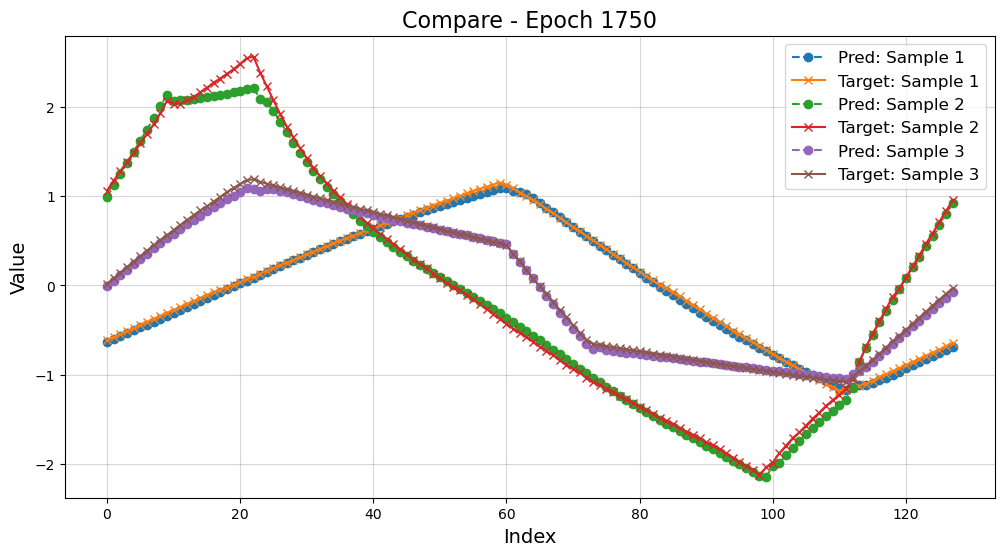

Epoch 1751, Train Loss: 0.002997, Validation Loss: 0.003242
Epoch 1752, Train Loss: 0.002959, Validation Loss: 0.002848
Epoch 1753, Train Loss: 0.002950, Validation Loss: 0.002979
Epoch 1754, Train Loss: 0.003013, Validation Loss: 0.002953
Epoch 1755, Train Loss: 0.002857, Validation Loss: 0.002872
Epoch 1756, Train Loss: 0.002848, Validation Loss: 0.002842
Epoch 1757, Train Loss: 0.002918, Validation Loss: 0.003675
Epoch 1758, Train Loss: 0.003181, Validation Loss: 0.002954
Epoch 1759, Train Loss: 0.002950, Validation Loss: 0.003041
Epoch 1760, Train Loss: 0.002891, Validation Loss: 0.002855
Epoch 1761, Train Loss: 0.002907, Validation Loss: 0.002928
Epoch 1762, Train Loss: 0.003031, Validation Loss: 0.003024
Epoch 1763, Train Loss: 0.003060, Validation Loss: 0.002922
Epoch 1764, Train Loss: 0.002849, Validation Loss: 0.002857
Epoch 1765, Train Loss: 0.002976, Validation Loss: 0.002919
Epoch 1766, Train Loss: 0.002965, Validation Loss: 0.002934
Epoch 1767, Train Loss: 0.002895, Valida

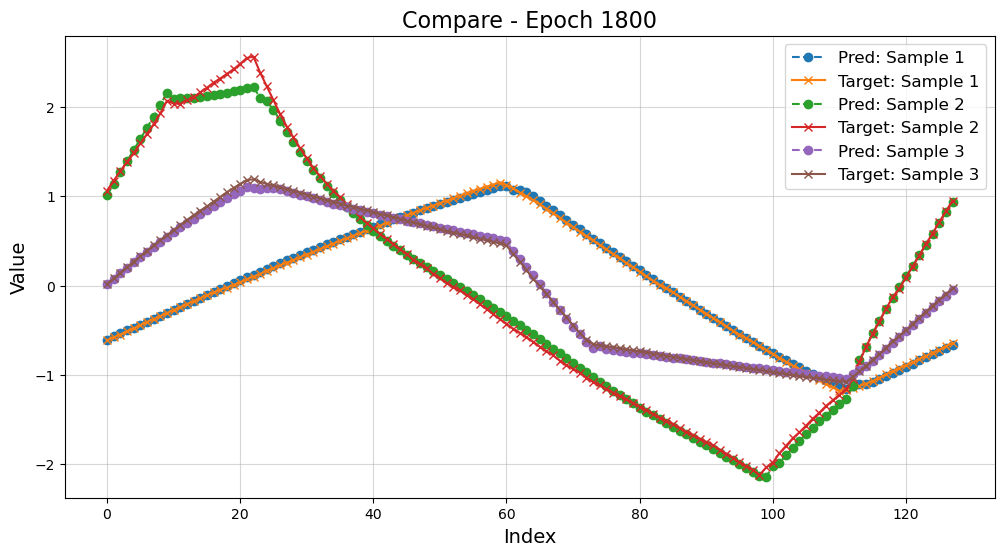

Epoch 1801, Train Loss: 0.002960, Validation Loss: 0.002917
Epoch 1802, Train Loss: 0.002916, Validation Loss: 0.003505
Epoch 1803, Train Loss: 0.003208, Validation Loss: 0.003826
Epoch 1804, Train Loss: 0.003213, Validation Loss: 0.003085
Epoch 1805, Train Loss: 0.003119, Validation Loss: 0.003246
Epoch 1806, Train Loss: 0.002912, Validation Loss: 0.002866
Epoch 1807, Train Loss: 0.002800, Validation Loss: 0.002900
Epoch 1808, Train Loss: 0.002958, Validation Loss: 0.003134
Epoch 1809, Train Loss: 0.002956, Validation Loss: 0.002919
Epoch 1810, Train Loss: 0.003044, Validation Loss: 0.002911
Epoch 1811, Train Loss: 0.002991, Validation Loss: 0.003033
Epoch 1812, Train Loss: 0.002960, Validation Loss: 0.002865
Epoch 1813, Train Loss: 0.003167, Validation Loss: 0.003071
Epoch 1814, Train Loss: 0.003639, Validation Loss: 0.003707
Epoch 1815, Train Loss: 0.003362, Validation Loss: 0.002945
Epoch 1816, Train Loss: 0.002853, Validation Loss: 0.002852
Epoch 1817, Train Loss: 0.002885, Valida

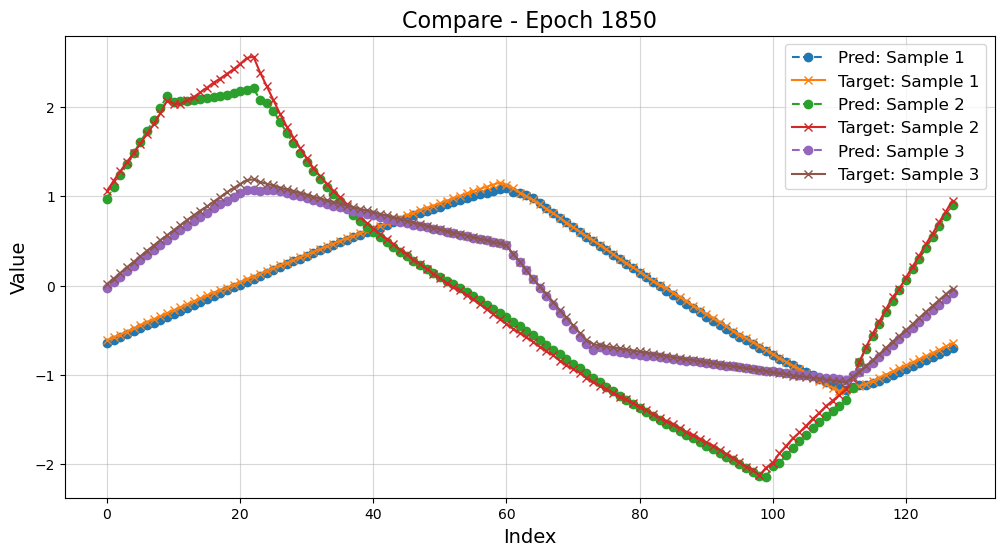

Epoch 1851, Train Loss: 0.003207, Validation Loss: 0.002840
Epoch 1852, Train Loss: 0.003107, Validation Loss: 0.003649
Epoch 1853, Train Loss: 0.003099, Validation Loss: 0.003038
Epoch 1854, Train Loss: 0.002859, Validation Loss: 0.002810
Epoch 1855, Train Loss: 0.002848, Validation Loss: 0.002899
Epoch 1856, Train Loss: 0.002994, Validation Loss: 0.003072
Epoch 1857, Train Loss: 0.002958, Validation Loss: 0.003142
Epoch 1858, Train Loss: 0.003026, Validation Loss: 0.003222
Epoch 1859, Train Loss: 0.002944, Validation Loss: 0.002917
Epoch 1860, Train Loss: 0.002893, Validation Loss: 0.002845
Epoch 1861, Train Loss: 0.002883, Validation Loss: 0.002876
Epoch 1862, Train Loss: 0.003023, Validation Loss: 0.003375
Epoch 1863, Train Loss: 0.002951, Validation Loss: 0.002784
Saving model at epoch 1863 with validation loss 0.002784...
Epoch 1864, Train Loss: 0.002860, Validation Loss: 0.003272
Epoch 1865, Train Loss: 0.003155, Validation Loss: 0.003066
Epoch 1866, Train Loss: 0.003095, Valida

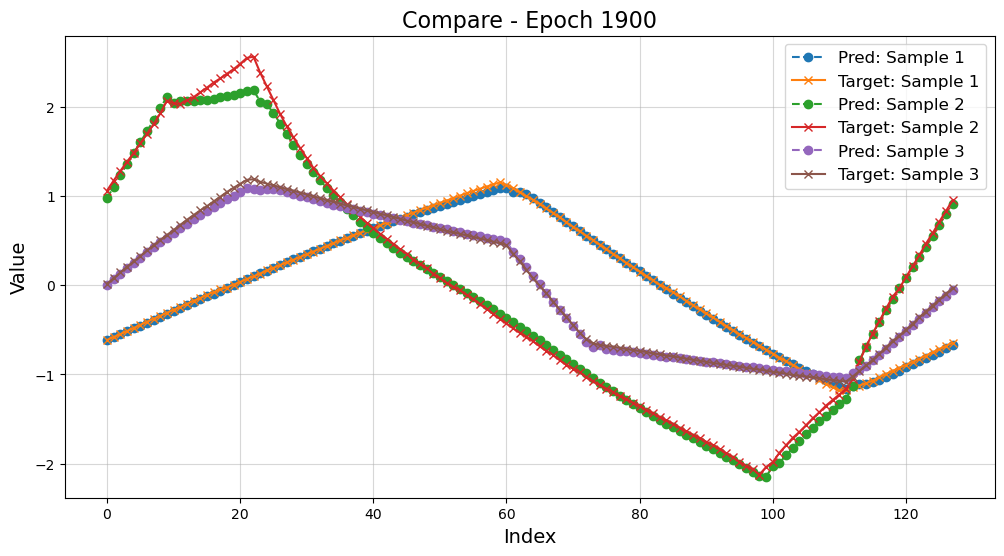

Epoch 1901, Train Loss: 0.002934, Validation Loss: 0.002843
Epoch 1902, Train Loss: 0.002861, Validation Loss: 0.002881
Epoch 1903, Train Loss: 0.002888, Validation Loss: 0.003123
Epoch 1904, Train Loss: 0.003103, Validation Loss: 0.003826
Epoch 1905, Train Loss: 0.003077, Validation Loss: 0.002975
Epoch 1906, Train Loss: 0.003035, Validation Loss: 0.002816
Epoch 1907, Train Loss: 0.002973, Validation Loss: 0.003011
Epoch 1908, Train Loss: 0.003216, Validation Loss: 0.002915
Epoch 1909, Train Loss: 0.003095, Validation Loss: 0.003013
Epoch 1910, Train Loss: 0.003027, Validation Loss: 0.003049
Epoch 1911, Train Loss: 0.003021, Validation Loss: 0.002947
Epoch 1912, Train Loss: 0.002929, Validation Loss: 0.002798
Epoch 1913, Train Loss: 0.002916, Validation Loss: 0.002897
Epoch 1914, Train Loss: 0.002820, Validation Loss: 0.002800
Epoch 1915, Train Loss: 0.002923, Validation Loss: 0.003231
Epoch 1916, Train Loss: 0.003133, Validation Loss: 0.002862
Epoch 1917, Train Loss: 0.002997, Valida

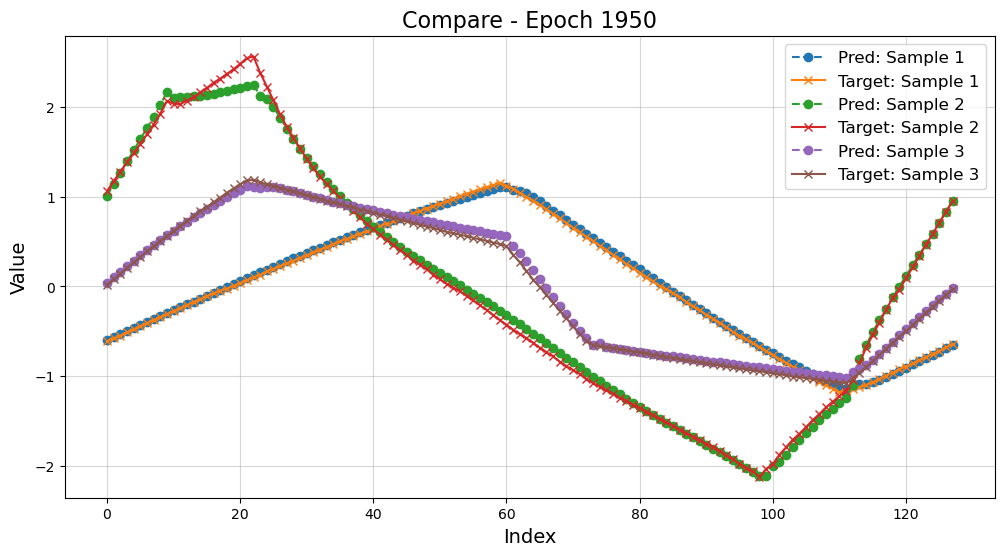

Epoch 1951, Train Loss: 0.002961, Validation Loss: 0.002939
Epoch 1952, Train Loss: 0.002876, Validation Loss: 0.002810
Epoch 1953, Train Loss: 0.002881, Validation Loss: 0.002809
Epoch 1954, Train Loss: 0.002814, Validation Loss: 0.002800
Epoch 1955, Train Loss: 0.002944, Validation Loss: 0.003137
Epoch 1956, Train Loss: 0.002984, Validation Loss: 0.003125
Epoch 1957, Train Loss: 0.002948, Validation Loss: 0.002868
Epoch 1958, Train Loss: 0.002916, Validation Loss: 0.003546
Epoch 1959, Train Loss: 0.002912, Validation Loss: 0.002784
Epoch 1960, Train Loss: 0.002839, Validation Loss: 0.002932
Epoch 1961, Train Loss: 0.002865, Validation Loss: 0.002848
Epoch 1962, Train Loss: 0.003129, Validation Loss: 0.002935
Epoch 1963, Train Loss: 0.003096, Validation Loss: 0.002987
Epoch 1964, Train Loss: 0.002942, Validation Loss: 0.002835
Epoch 1965, Train Loss: 0.002875, Validation Loss: 0.002838
Epoch 1966, Train Loss: 0.002922, Validation Loss: 0.003015
Epoch 1967, Train Loss: 0.002979, Valida

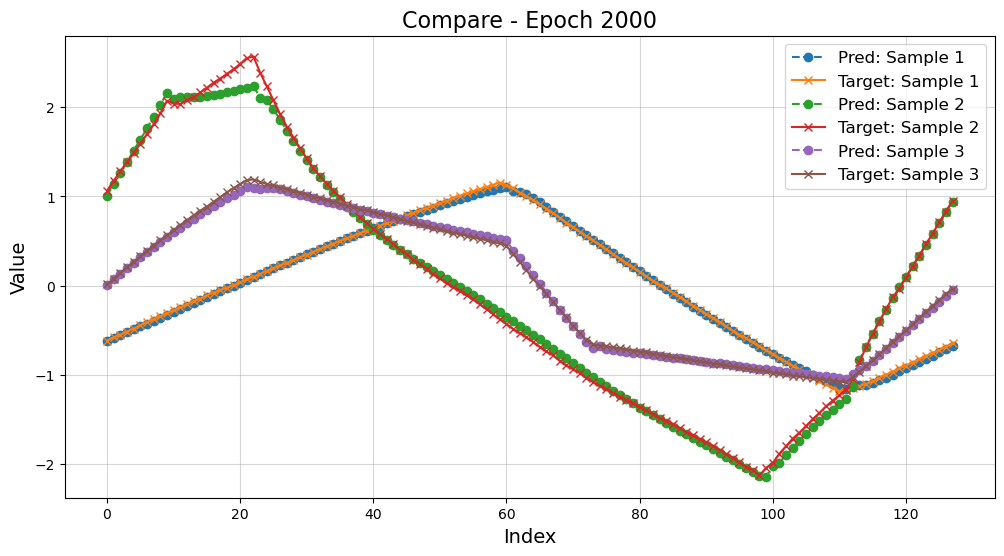

Epoch 2001, Train Loss: 0.002832, Validation Loss: 0.003134
Epoch 2002, Train Loss: 0.003176, Validation Loss: 0.003213
Epoch 2003, Train Loss: 0.003158, Validation Loss: 0.002964
Epoch 2004, Train Loss: 0.002856, Validation Loss: 0.002886
Epoch 2005, Train Loss: 0.002781, Validation Loss: 0.002814
Epoch 2006, Train Loss: 0.002912, Validation Loss: 0.003063
Epoch 2007, Train Loss: 0.002926, Validation Loss: 0.002783
Epoch 2008, Train Loss: 0.002973, Validation Loss: 0.002845
Epoch 2009, Train Loss: 0.002905, Validation Loss: 0.003085
Epoch 2010, Train Loss: 0.002891, Validation Loss: 0.002851
Epoch 2011, Train Loss: 0.002831, Validation Loss: 0.002777
Epoch 2012, Train Loss: 0.002815, Validation Loss: 0.002943
Epoch 2013, Train Loss: 0.002898, Validation Loss: 0.002947
Epoch 2014, Train Loss: 0.002858, Validation Loss: 0.003141
Epoch 2015, Train Loss: 0.002944, Validation Loss: 0.002863
Epoch 2016, Train Loss: 0.002912, Validation Loss: 0.002788
Epoch 2017, Train Loss: 0.002919, Valida

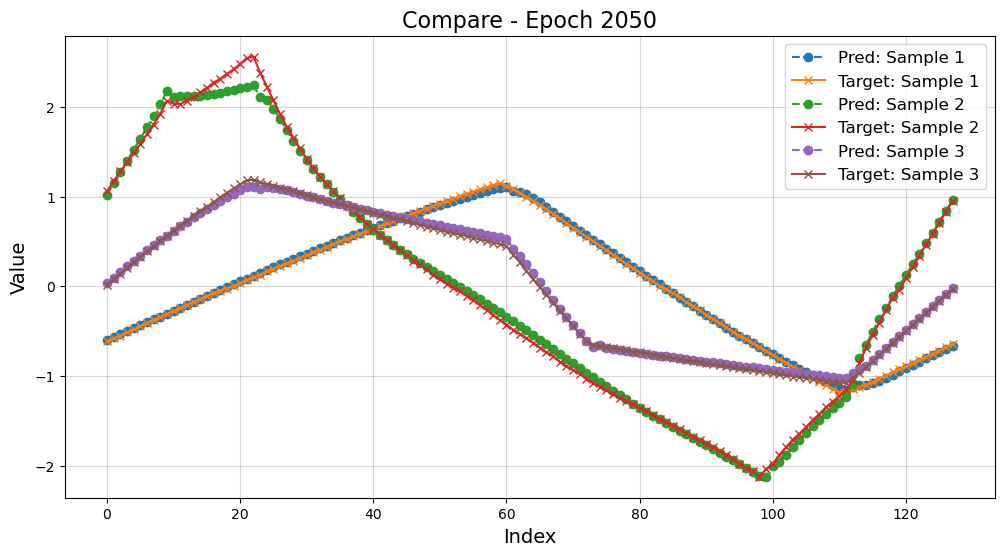

Epoch 2051, Train Loss: 0.002916, Validation Loss: 0.002834
Epoch 2052, Train Loss: 0.002856, Validation Loss: 0.002945
Epoch 2053, Train Loss: 0.003093, Validation Loss: 0.002870
Epoch 2054, Train Loss: 0.002809, Validation Loss: 0.002862
Epoch 2055, Train Loss: 0.002791, Validation Loss: 0.002909
Epoch 2056, Train Loss: 0.002900, Validation Loss: 0.002784
Epoch 2057, Train Loss: 0.002820, Validation Loss: 0.002804
Epoch 2058, Train Loss: 0.002864, Validation Loss: 0.002828
Epoch 2059, Train Loss: 0.002956, Validation Loss: 0.002803
Epoch 2060, Train Loss: 0.002870, Validation Loss: 0.002956
Epoch 2061, Train Loss: 0.003064, Validation Loss: 0.002780
Epoch 2062, Train Loss: 0.002848, Validation Loss: 0.002777
Epoch 2063, Train Loss: 0.002841, Validation Loss: 0.002929
Epoch 2064, Train Loss: 0.002888, Validation Loss: 0.002879
Epoch 2065, Train Loss: 0.002841, Validation Loss: 0.002962
Epoch 2066, Train Loss: 0.003035, Validation Loss: 0.002804
Epoch 2067, Train Loss: 0.003119, Valida

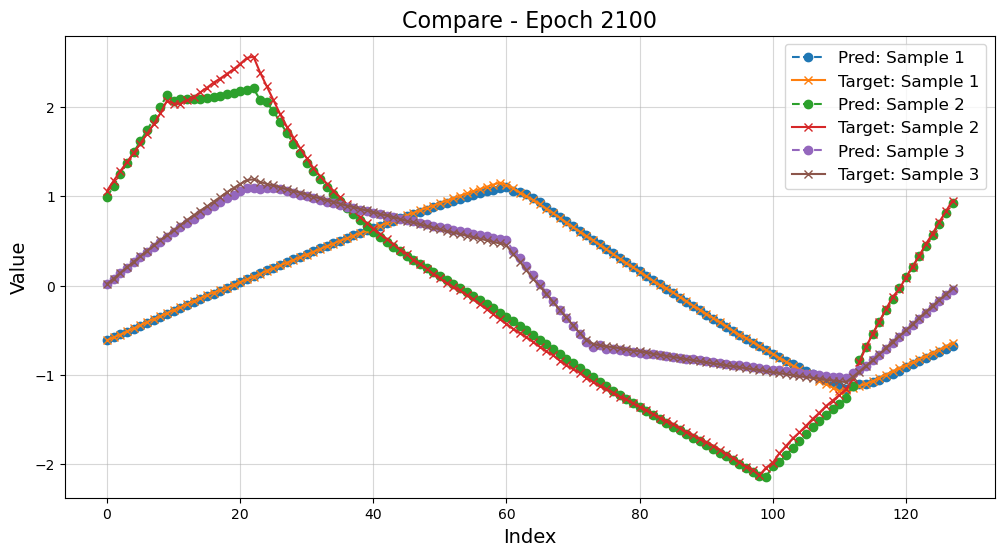

Epoch 2101, Train Loss: 0.002988, Validation Loss: 0.003360
Epoch 2102, Train Loss: 0.003011, Validation Loss: 0.002758
Saving model at epoch 2102 with validation loss 0.002758...
Epoch 2103, Train Loss: 0.002929, Validation Loss: 0.002770
Epoch 2104, Train Loss: 0.002776, Validation Loss: 0.002863
Epoch 2105, Train Loss: 0.002798, Validation Loss: 0.002792
Epoch 2106, Train Loss: 0.002840, Validation Loss: 0.002793
Epoch 2107, Train Loss: 0.002883, Validation Loss: 0.003059
Epoch 2108, Train Loss: 0.002858, Validation Loss: 0.002767
Epoch 2109, Train Loss: 0.002961, Validation Loss: 0.003130
Epoch 2110, Train Loss: 0.002877, Validation Loss: 0.002993
Epoch 2111, Train Loss: 0.002850, Validation Loss: 0.003464
Epoch 2112, Train Loss: 0.003027, Validation Loss: 0.002763
Epoch 2113, Train Loss: 0.002860, Validation Loss: 0.002805
Epoch 2114, Train Loss: 0.002781, Validation Loss: 0.002842
Epoch 2115, Train Loss: 0.002767, Validation Loss: 0.002907
Epoch 2116, Train Loss: 0.002886, Valida

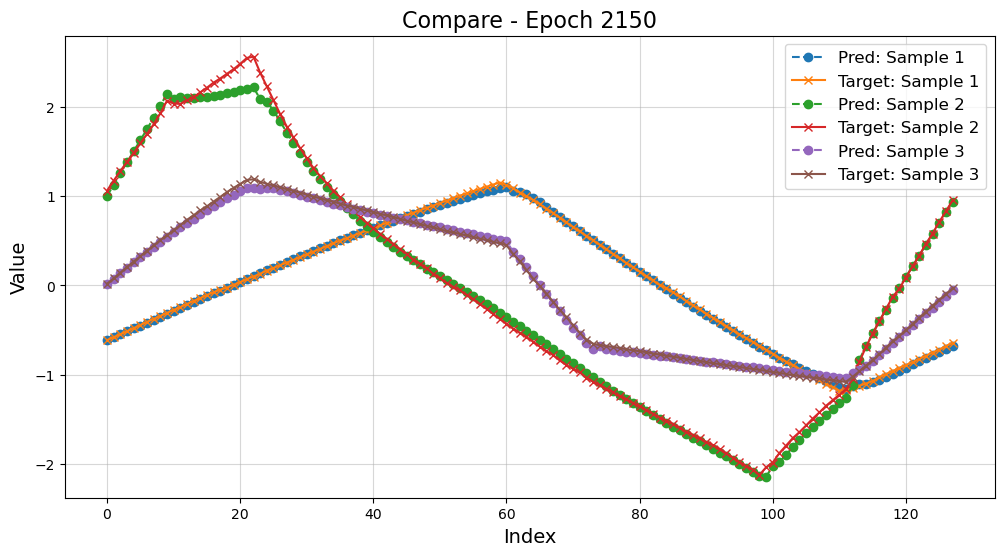

Saving model at epoch 2150 with validation loss 0.002735...
Epoch 2151, Train Loss: 0.002744, Validation Loss: 0.002741
Epoch 2152, Train Loss: 0.002853, Validation Loss: 0.002812
Epoch 2153, Train Loss: 0.002806, Validation Loss: 0.002896
Epoch 2154, Train Loss: 0.002806, Validation Loss: 0.002749
Epoch 2155, Train Loss: 0.002853, Validation Loss: 0.003025
Epoch 2156, Train Loss: 0.002808, Validation Loss: 0.002743
Epoch 2157, Train Loss: 0.002923, Validation Loss: 0.003046
Epoch 2158, Train Loss: 0.002977, Validation Loss: 0.003136
Epoch 2159, Train Loss: 0.002957, Validation Loss: 0.002981
Epoch 2160, Train Loss: 0.002900, Validation Loss: 0.002919
Epoch 2161, Train Loss: 0.002856, Validation Loss: 0.002752
Epoch 2162, Train Loss: 0.002889, Validation Loss: 0.002745
Epoch 2163, Train Loss: 0.002741, Validation Loss: 0.002985
Epoch 2164, Train Loss: 0.002838, Validation Loss: 0.002748
Epoch 2165, Train Loss: 0.002845, Validation Loss: 0.002904
Epoch 2166, Train Loss: 0.003059, Valida

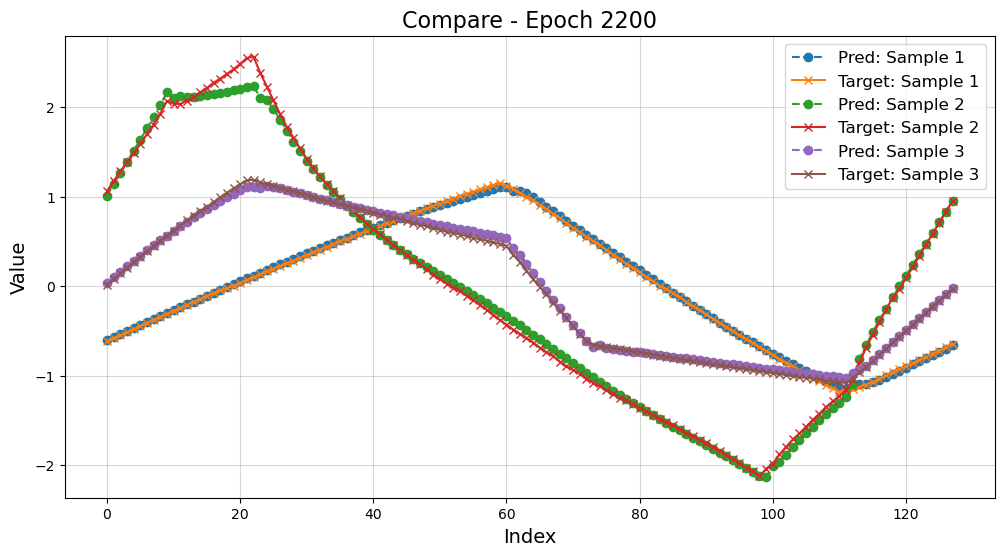

Epoch 2201, Train Loss: 0.003049, Validation Loss: 0.003827
Epoch 2202, Train Loss: 0.002960, Validation Loss: 0.002822
Epoch 2203, Train Loss: 0.002851, Validation Loss: 0.003171
Epoch 2204, Train Loss: 0.002839, Validation Loss: 0.002751
Epoch 2205, Train Loss: 0.002951, Validation Loss: 0.003151
Epoch 2206, Train Loss: 0.002987, Validation Loss: 0.003006
Epoch 2207, Train Loss: 0.002823, Validation Loss: 0.002898
Epoch 2208, Train Loss: 0.002851, Validation Loss: 0.002765
Epoch 2209, Train Loss: 0.002931, Validation Loss: 0.002777
Epoch 2210, Train Loss: 0.002860, Validation Loss: 0.002875
Epoch 2211, Train Loss: 0.002867, Validation Loss: 0.002765
Epoch 2212, Train Loss: 0.002908, Validation Loss: 0.002753
Epoch 2213, Train Loss: 0.002795, Validation Loss: 0.002777
Epoch 2214, Train Loss: 0.002835, Validation Loss: 0.002872
Epoch 2215, Train Loss: 0.002852, Validation Loss: 0.002773
Epoch 2216, Train Loss: 0.002803, Validation Loss: 0.002846
Epoch 2217, Train Loss: 0.003023, Valida

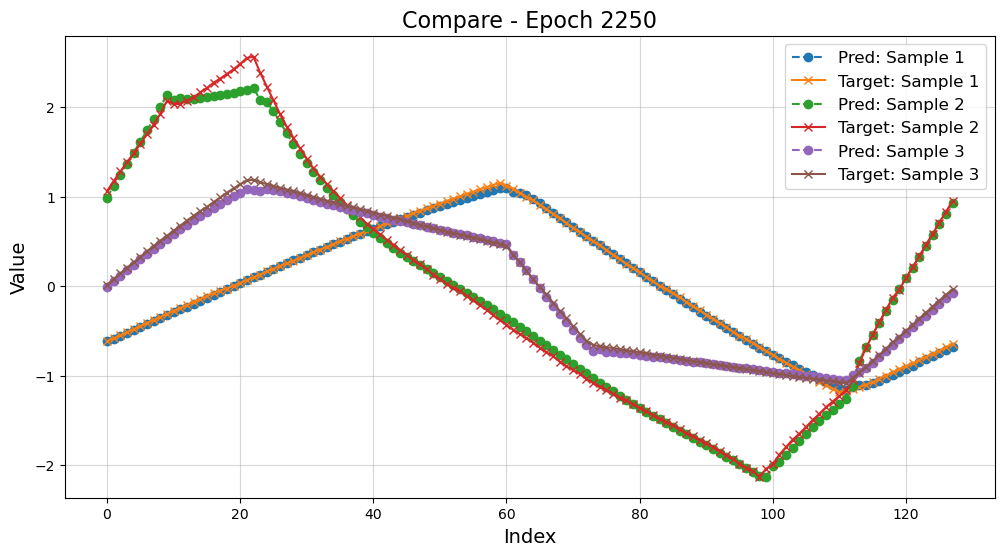

Epoch 2251, Train Loss: 0.002795, Validation Loss: 0.002775
Epoch 2252, Train Loss: 0.002843, Validation Loss: 0.002740
Epoch 2253, Train Loss: 0.002786, Validation Loss: 0.002792
Epoch 2254, Train Loss: 0.002794, Validation Loss: 0.002774
Epoch 2255, Train Loss: 0.002769, Validation Loss: 0.002930
Epoch 2256, Train Loss: 0.002865, Validation Loss: 0.002809
Epoch 2257, Train Loss: 0.003128, Validation Loss: 0.002800
Epoch 2258, Train Loss: 0.003187, Validation Loss: 0.003278
Epoch 2259, Train Loss: 0.002858, Validation Loss: 0.002781
Epoch 2260, Train Loss: 0.002912, Validation Loss: 0.002943
Epoch 2261, Train Loss: 0.002825, Validation Loss: 0.002732
Epoch 2262, Train Loss: 0.002753, Validation Loss: 0.002819
Epoch 2263, Train Loss: 0.002867, Validation Loss: 0.002719
Saving model at epoch 2263 with validation loss 0.002719...
Epoch 2264, Train Loss: 0.002884, Validation Loss: 0.002839
Epoch 2265, Train Loss: 0.002768, Validation Loss: 0.002954
Epoch 2266, Train Loss: 0.003022, Valida

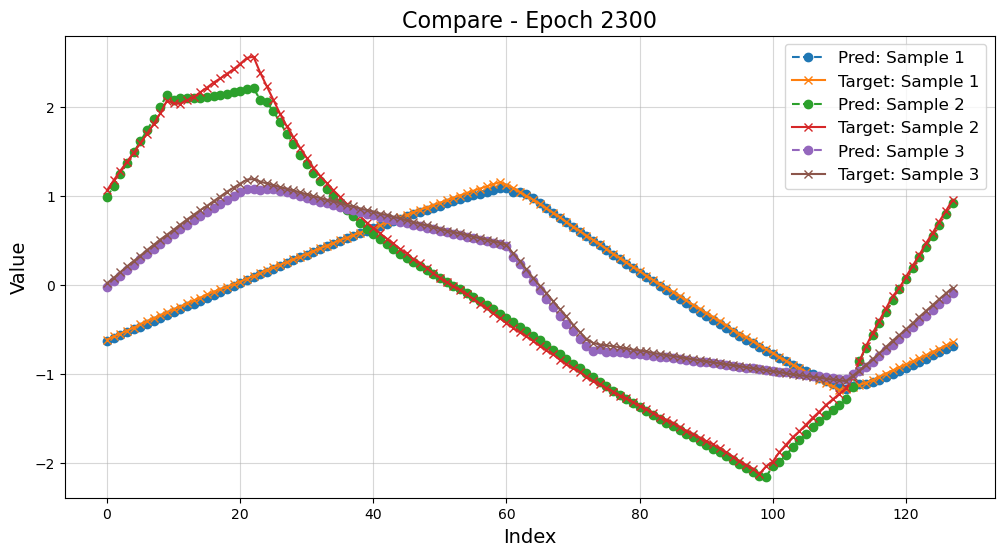

Epoch 2301, Train Loss: 0.002862, Validation Loss: 0.002990
Epoch 2302, Train Loss: 0.002762, Validation Loss: 0.002811
Epoch 2303, Train Loss: 0.002829, Validation Loss: 0.002794
Epoch 2304, Train Loss: 0.002948, Validation Loss: 0.002860
Epoch 2305, Train Loss: 0.002825, Validation Loss: 0.002722
Epoch 2306, Train Loss: 0.002957, Validation Loss: 0.003277
Epoch 2307, Train Loss: 0.003080, Validation Loss: 0.003064
Epoch 2308, Train Loss: 0.003100, Validation Loss: 0.002889
Epoch 2309, Train Loss: 0.002808, Validation Loss: 0.002799
Epoch 2310, Train Loss: 0.002748, Validation Loss: 0.002941
Epoch 2311, Train Loss: 0.002823, Validation Loss: 0.002803
Epoch 2312, Train Loss: 0.002899, Validation Loss: 0.003509
Epoch 2313, Train Loss: 0.002939, Validation Loss: 0.002787
Epoch 2314, Train Loss: 0.002852, Validation Loss: 0.002796
Epoch 2315, Train Loss: 0.002820, Validation Loss: 0.003021
Epoch 2316, Train Loss: 0.002837, Validation Loss: 0.002922
Epoch 2317, Train Loss: 0.002864, Valida

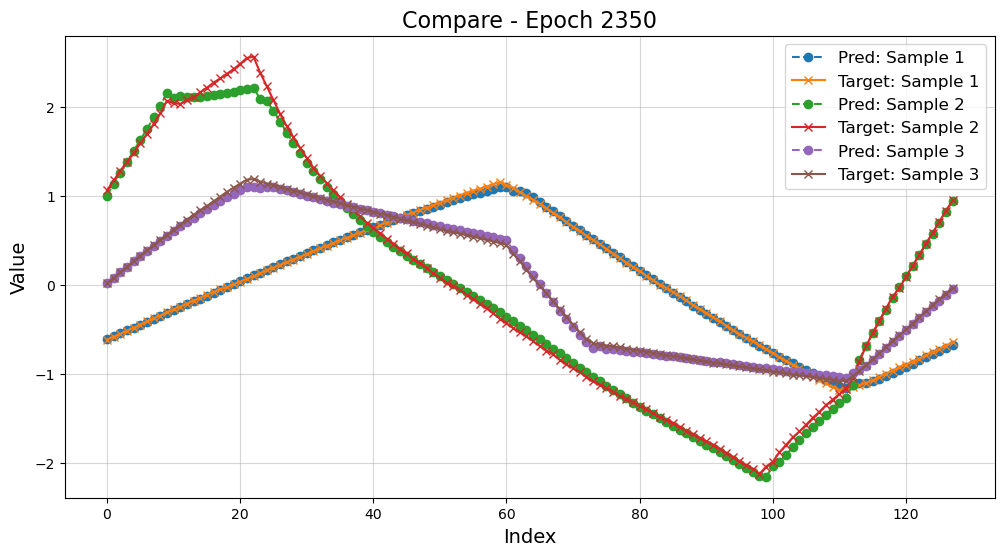

Saving model at epoch 2350 with validation loss 0.002695...
Epoch 2351, Train Loss: 0.002831, Validation Loss: 0.002796
Epoch 2352, Train Loss: 0.002831, Validation Loss: 0.002750
Epoch 2353, Train Loss: 0.002780, Validation Loss: 0.003663
Epoch 2354, Train Loss: 0.003020, Validation Loss: 0.002796
Epoch 2355, Train Loss: 0.002792, Validation Loss: 0.002760
Epoch 2356, Train Loss: 0.002836, Validation Loss: 0.002897
Epoch 2357, Train Loss: 0.002871, Validation Loss: 0.002851
Epoch 2358, Train Loss: 0.002793, Validation Loss: 0.002734
Epoch 2359, Train Loss: 0.002702, Validation Loss: 0.002737
Epoch 2360, Train Loss: 0.002724, Validation Loss: 0.002763
Epoch 2361, Train Loss: 0.002783, Validation Loss: 0.002734
Epoch 2362, Train Loss: 0.002853, Validation Loss: 0.002751
Epoch 2363, Train Loss: 0.002764, Validation Loss: 0.002742
Epoch 2364, Train Loss: 0.002761, Validation Loss: 0.002726
Epoch 2365, Train Loss: 0.002716, Validation Loss: 0.002785
Epoch 2366, Train Loss: 0.002759, Valida

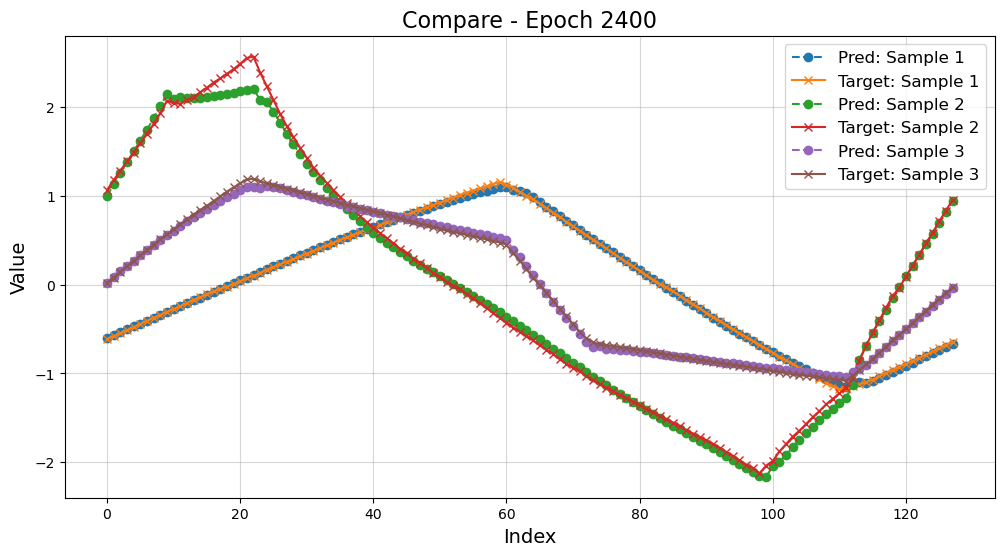

Epoch 2401, Train Loss: 0.002821, Validation Loss: 0.002739
Epoch 2402, Train Loss: 0.002867, Validation Loss: 0.002806
Epoch 2403, Train Loss: 0.002768, Validation Loss: 0.002772
Epoch 2404, Train Loss: 0.002915, Validation Loss: 0.002883
Epoch 2405, Train Loss: 0.002776, Validation Loss: 0.002747
Epoch 2406, Train Loss: 0.002797, Validation Loss: 0.002870
Epoch 2407, Train Loss: 0.002976, Validation Loss: 0.003371
Epoch 2408, Train Loss: 0.003172, Validation Loss: 0.002744
Epoch 2409, Train Loss: 0.002772, Validation Loss: 0.002710
Epoch 2410, Train Loss: 0.002869, Validation Loss: 0.003208
Epoch 2411, Train Loss: 0.002802, Validation Loss: 0.002716
Epoch 2412, Train Loss: 0.002781, Validation Loss: 0.002984
Epoch 2413, Train Loss: 0.002900, Validation Loss: 0.002859
Epoch 2414, Train Loss: 0.002801, Validation Loss: 0.003193
Epoch 2415, Train Loss: 0.002842, Validation Loss: 0.002795
Epoch 2416, Train Loss: 0.002790, Validation Loss: 0.002857
Epoch 2417, Train Loss: 0.002843, Valida

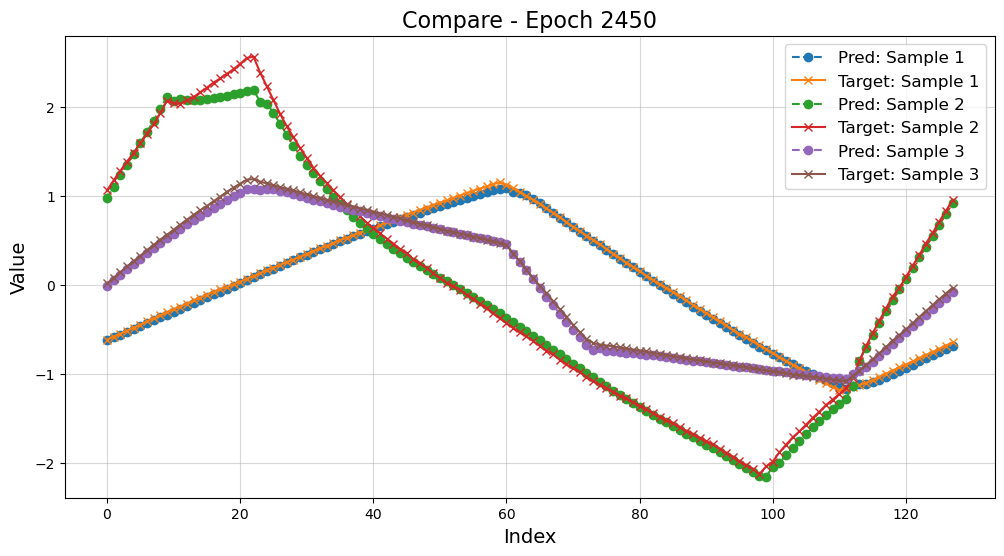

Epoch 2451, Train Loss: 0.002755, Validation Loss: 0.002814
Epoch 2452, Train Loss: 0.002925, Validation Loss: 0.002704
Epoch 2453, Train Loss: 0.002846, Validation Loss: 0.002740
Epoch 2454, Train Loss: 0.002807, Validation Loss: 0.002971
Epoch 2455, Train Loss: 0.002915, Validation Loss: 0.002904
Epoch 2456, Train Loss: 0.002977, Validation Loss: 0.002832
Epoch 2457, Train Loss: 0.003100, Validation Loss: 0.003275
Epoch 2458, Train Loss: 0.002907, Validation Loss: 0.002778
Epoch 2459, Train Loss: 0.002872, Validation Loss: 0.003750
Epoch 2460, Train Loss: 0.003142, Validation Loss: 0.002705
Epoch 2461, Train Loss: 0.003037, Validation Loss: 0.002987
Epoch 2462, Train Loss: 0.002870, Validation Loss: 0.003005
Epoch 2463, Train Loss: 0.002768, Validation Loss: 0.002728
Epoch 2464, Train Loss: 0.002727, Validation Loss: 0.002928
Epoch 2465, Train Loss: 0.002925, Validation Loss: 0.002713
Epoch 2466, Train Loss: 0.002750, Validation Loss: 0.002904
Epoch 2467, Train Loss: 0.002840, Valida

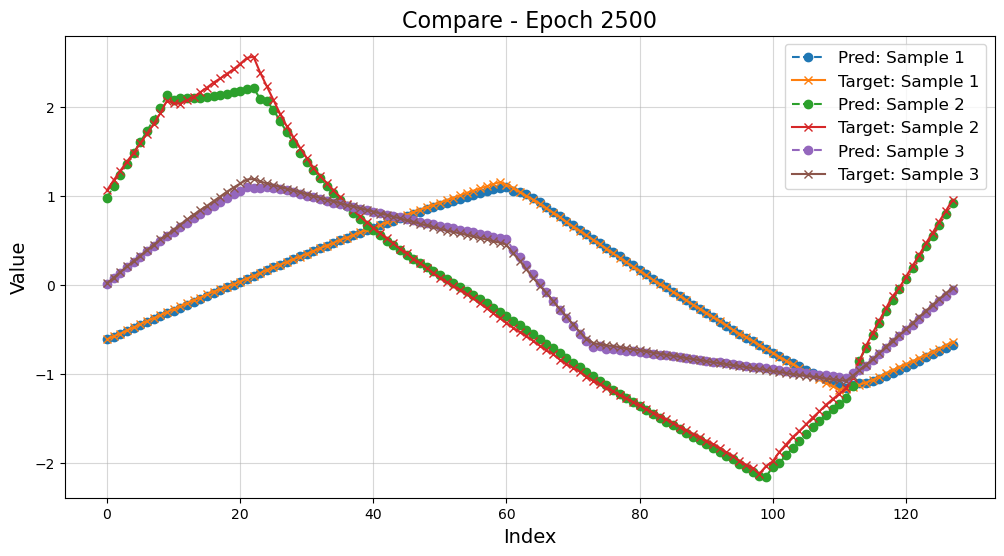

Epoch 2501, Train Loss: 0.002750, Validation Loss: 0.002740
Epoch 2502, Train Loss: 0.002742, Validation Loss: 0.002896
Epoch 2503, Train Loss: 0.002861, Validation Loss: 0.002758
Epoch 2504, Train Loss: 0.002908, Validation Loss: 0.002860
Epoch 2505, Train Loss: 0.002760, Validation Loss: 0.002743
Epoch 2506, Train Loss: 0.002731, Validation Loss: 0.002693
Epoch 2507, Train Loss: 0.002828, Validation Loss: 0.002938
Epoch 2508, Train Loss: 0.002792, Validation Loss: 0.002878
Epoch 2509, Train Loss: 0.002777, Validation Loss: 0.002700
Epoch 2510, Train Loss: 0.002707, Validation Loss: 0.002743
Epoch 2511, Train Loss: 0.002755, Validation Loss: 0.002691
Epoch 2512, Train Loss: 0.002715, Validation Loss: 0.003171
Epoch 2513, Train Loss: 0.003013, Validation Loss: 0.002718
Epoch 2514, Train Loss: 0.002869, Validation Loss: 0.002726
Epoch 2515, Train Loss: 0.002721, Validation Loss: 0.002995
Epoch 2516, Train Loss: 0.002727, Validation Loss: 0.002686
Epoch 2517, Train Loss: 0.002723, Valida

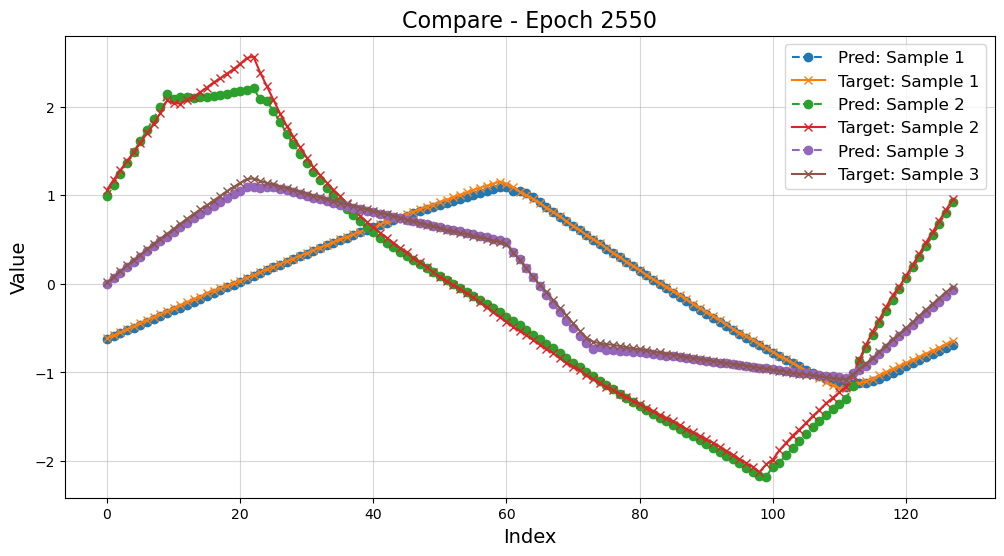

Epoch 2551, Train Loss: 0.002737, Validation Loss: 0.002717
Epoch 2552, Train Loss: 0.002719, Validation Loss: 0.002700
Epoch 2553, Train Loss: 0.003081, Validation Loss: 0.003108
Epoch 2554, Train Loss: 0.002944, Validation Loss: 0.003095
Epoch 2555, Train Loss: 0.002834, Validation Loss: 0.002781
Epoch 2556, Train Loss: 0.002748, Validation Loss: 0.003289
Epoch 2557, Train Loss: 0.002813, Validation Loss: 0.002806
Epoch 2558, Train Loss: 0.002714, Validation Loss: 0.002802
Epoch 2559, Train Loss: 0.002768, Validation Loss: 0.002799
Epoch 2560, Train Loss: 0.002722, Validation Loss: 0.002690
Epoch 2561, Train Loss: 0.002728, Validation Loss: 0.002969
Epoch 2562, Train Loss: 0.002775, Validation Loss: 0.003254
Epoch 2563, Train Loss: 0.002771, Validation Loss: 0.002726
Epoch 2564, Train Loss: 0.002809, Validation Loss: 0.002973
Epoch 2565, Train Loss: 0.002829, Validation Loss: 0.003190
Epoch 2566, Train Loss: 0.002856, Validation Loss: 0.002743
Epoch 2567, Train Loss: 0.002711, Valida

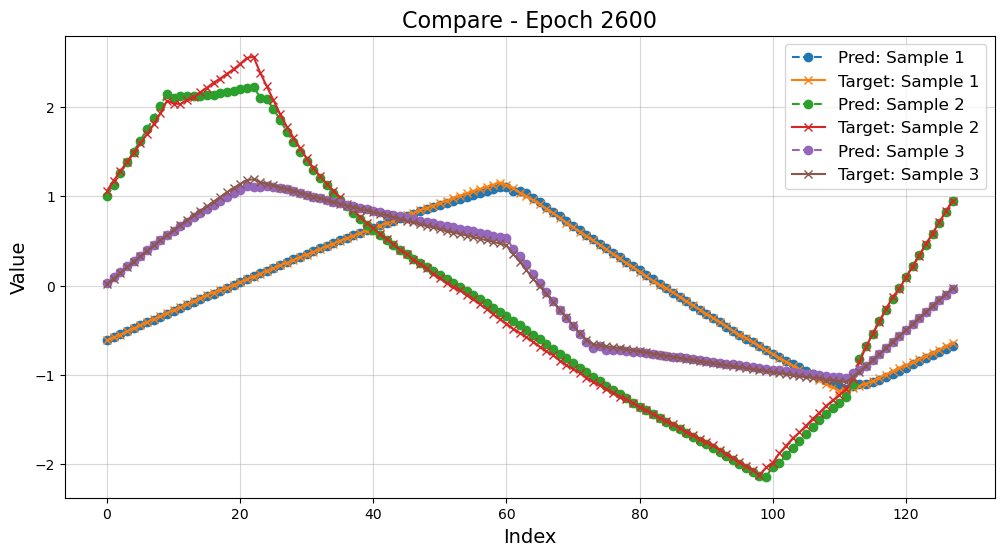

Epoch 2601, Train Loss: 0.002801, Validation Loss: 0.002691
Epoch 2602, Train Loss: 0.002764, Validation Loss: 0.002830
Epoch 2603, Train Loss: 0.002832, Validation Loss: 0.002830
Epoch 2604, Train Loss: 0.002841, Validation Loss: 0.003175
Epoch 2605, Train Loss: 0.002847, Validation Loss: 0.002750
Epoch 2606, Train Loss: 0.002702, Validation Loss: 0.002735
Epoch 2607, Train Loss: 0.002741, Validation Loss: 0.003033
Epoch 2608, Train Loss: 0.002858, Validation Loss: 0.002778
Epoch 2609, Train Loss: 0.002720, Validation Loss: 0.002792
Epoch 2610, Train Loss: 0.002878, Validation Loss: 0.003440
Epoch 2611, Train Loss: 0.002879, Validation Loss: 0.002783
Epoch 2612, Train Loss: 0.002773, Validation Loss: 0.002946
Epoch 2613, Train Loss: 0.002775, Validation Loss: 0.002727
Epoch 2614, Train Loss: 0.002885, Validation Loss: 0.003267
Epoch 2615, Train Loss: 0.002866, Validation Loss: 0.002717
Epoch 2616, Train Loss: 0.002840, Validation Loss: 0.002778
Epoch 2617, Train Loss: 0.002752, Valida

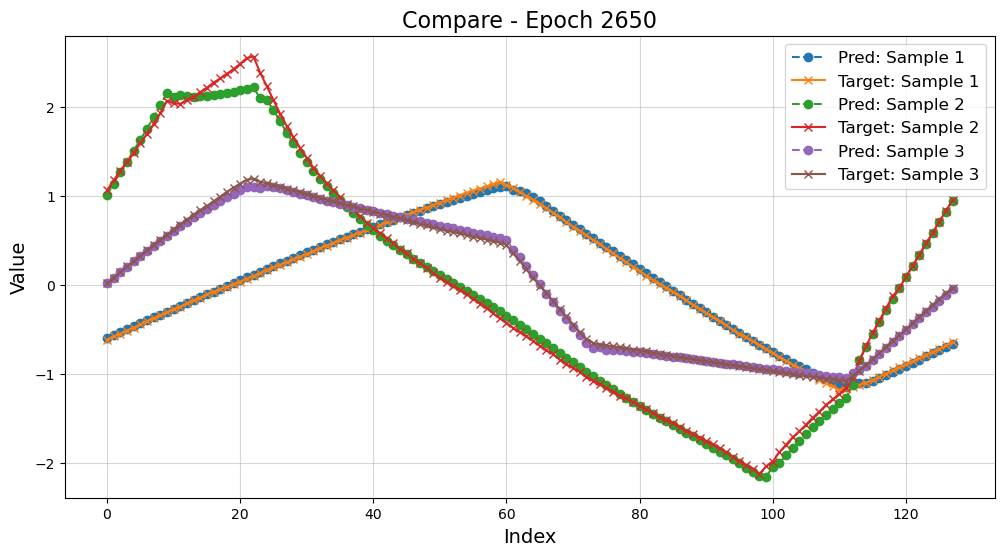

Epoch 2651, Train Loss: 0.002780, Validation Loss: 0.002707
Epoch 2652, Train Loss: 0.002696, Validation Loss: 0.002910
Epoch 2653, Train Loss: 0.002771, Validation Loss: 0.002771
Epoch 2654, Train Loss: 0.002683, Validation Loss: 0.002753
Epoch 2655, Train Loss: 0.002705, Validation Loss: 0.002877
Epoch 2656, Train Loss: 0.002762, Validation Loss: 0.002761
Epoch 2657, Train Loss: 0.002697, Validation Loss: 0.002815
Epoch 2658, Train Loss: 0.002726, Validation Loss: 0.002678
Epoch 2659, Train Loss: 0.002722, Validation Loss: 0.002772
Epoch 2660, Train Loss: 0.002770, Validation Loss: 0.002799
Epoch 2661, Train Loss: 0.002791, Validation Loss: 0.002834
Epoch 2662, Train Loss: 0.002800, Validation Loss: 0.002767
Epoch 2663, Train Loss: 0.002747, Validation Loss: 0.002708
Epoch 2664, Train Loss: 0.002878, Validation Loss: 0.002742
Epoch 2665, Train Loss: 0.002812, Validation Loss: 0.002990
Epoch 2666, Train Loss: 0.002948, Validation Loss: 0.003004
Epoch 2667, Train Loss: 0.002991, Valida

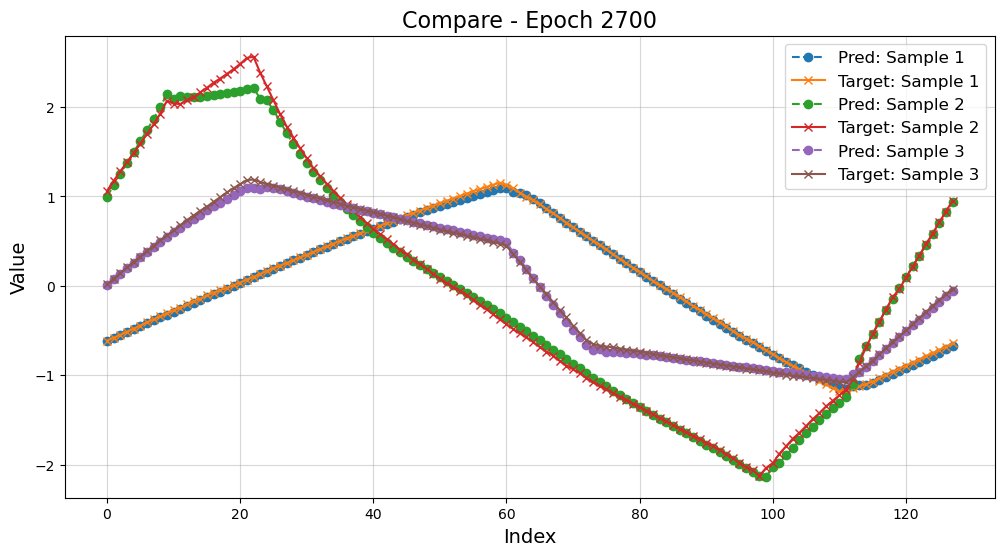

Epoch 2701, Train Loss: 0.002720, Validation Loss: 0.002800
Epoch 2702, Train Loss: 0.002690, Validation Loss: 0.002710
Epoch 2703, Train Loss: 0.002760, Validation Loss: 0.002694
Epoch 2704, Train Loss: 0.002841, Validation Loss: 0.002707
Epoch 2705, Train Loss: 0.002687, Validation Loss: 0.002933
Epoch 2706, Train Loss: 0.002731, Validation Loss: 0.002679
Epoch 2707, Train Loss: 0.002649, Validation Loss: 0.002885
Epoch 2708, Train Loss: 0.002702, Validation Loss: 0.002804
Epoch 2709, Train Loss: 0.002687, Validation Loss: 0.002741
Epoch 2710, Train Loss: 0.002671, Validation Loss: 0.003395
Epoch 2711, Train Loss: 0.003140, Validation Loss: 0.002721
Epoch 2712, Train Loss: 0.003000, Validation Loss: 0.002738
Epoch 2713, Train Loss: 0.002898, Validation Loss: 0.002789
Epoch 2714, Train Loss: 0.002846, Validation Loss: 0.003059
Epoch 2715, Train Loss: 0.002967, Validation Loss: 0.002814
Epoch 2716, Train Loss: 0.002743, Validation Loss: 0.002802
Epoch 2717, Train Loss: 0.002720, Valida

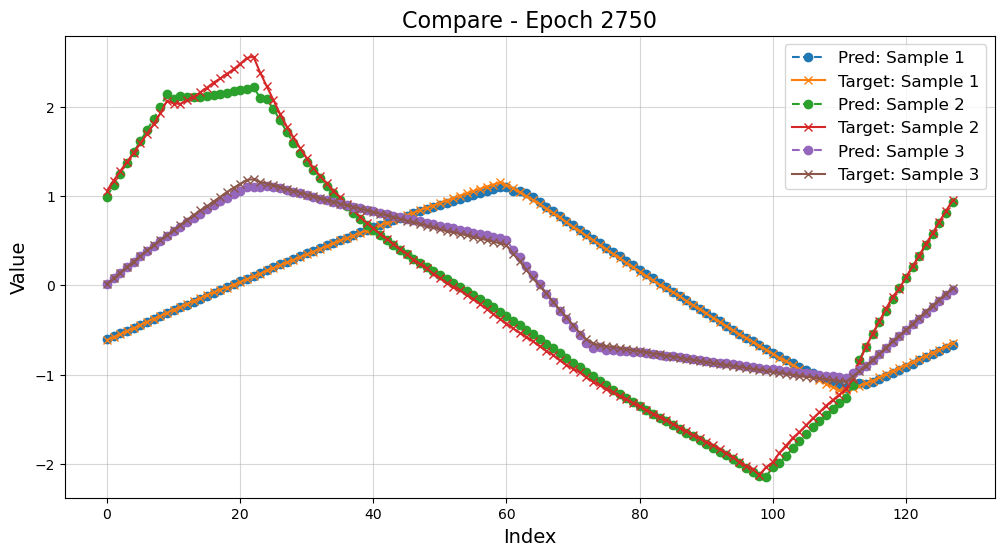

Epoch 2751, Train Loss: 0.002687, Validation Loss: 0.002764
Epoch 2752, Train Loss: 0.002728, Validation Loss: 0.002711
Epoch 2753, Train Loss: 0.002747, Validation Loss: 0.002751
Epoch 2754, Train Loss: 0.002777, Validation Loss: 0.002643
Epoch 2755, Train Loss: 0.002746, Validation Loss: 0.002758
Epoch 2756, Train Loss: 0.002723, Validation Loss: 0.002806
Epoch 2757, Train Loss: 0.002786, Validation Loss: 0.003615
Epoch 2758, Train Loss: 0.003076, Validation Loss: 0.002663
Epoch 2759, Train Loss: 0.002734, Validation Loss: 0.002700
Epoch 2760, Train Loss: 0.002650, Validation Loss: 0.002994
Epoch 2761, Train Loss: 0.002766, Validation Loss: 0.003349
Epoch 2762, Train Loss: 0.003091, Validation Loss: 0.003554
Epoch 2763, Train Loss: 0.003111, Validation Loss: 0.003220
Epoch 2764, Train Loss: 0.002903, Validation Loss: 0.003285
Epoch 2765, Train Loss: 0.003154, Validation Loss: 0.003349
Epoch 2766, Train Loss: 0.003116, Validation Loss: 0.002769
Epoch 2767, Train Loss: 0.002795, Valida

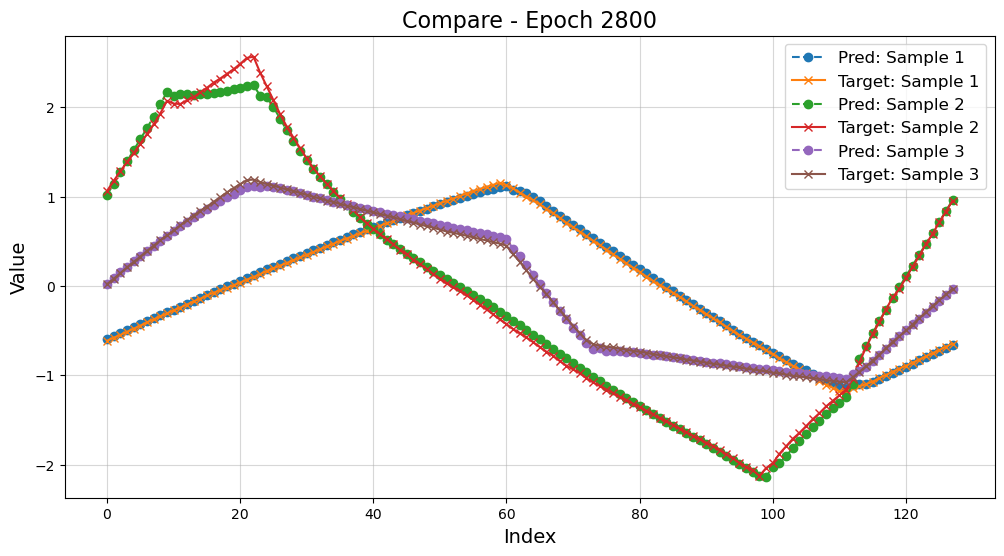

Epoch 2801, Train Loss: 0.002989, Validation Loss: 0.002669
Epoch 2802, Train Loss: 0.002723, Validation Loss: 0.002727
Epoch 2803, Train Loss: 0.002742, Validation Loss: 0.002901
Epoch 2804, Train Loss: 0.002790, Validation Loss: 0.002694
Epoch 2805, Train Loss: 0.002678, Validation Loss: 0.002684
Epoch 2806, Train Loss: 0.002680, Validation Loss: 0.002676
Epoch 2807, Train Loss: 0.002633, Validation Loss: 0.002647
Epoch 2808, Train Loss: 0.002639, Validation Loss: 0.002752
Epoch 2809, Train Loss: 0.002775, Validation Loss: 0.002777
Epoch 2810, Train Loss: 0.002803, Validation Loss: 0.002726
Epoch 2811, Train Loss: 0.002799, Validation Loss: 0.002694
Epoch 2812, Train Loss: 0.002663, Validation Loss: 0.002640
Epoch 2813, Train Loss: 0.002632, Validation Loss: 0.002725
Epoch 2814, Train Loss: 0.002823, Validation Loss: 0.002723
Epoch 2815, Train Loss: 0.002721, Validation Loss: 0.002683
Epoch 2816, Train Loss: 0.002697, Validation Loss: 0.003002
Epoch 2817, Train Loss: 0.002732, Valida

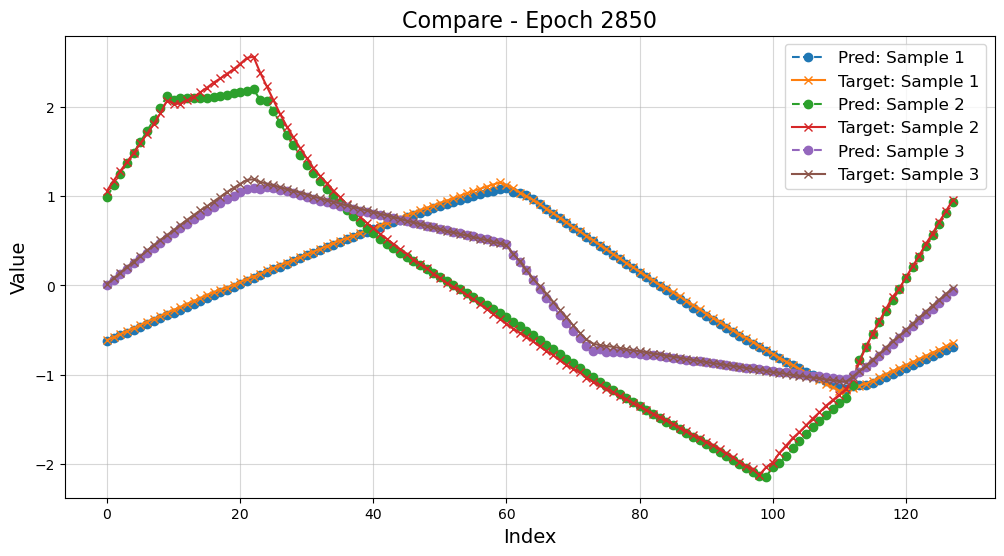

Epoch 2851, Train Loss: 0.002696, Validation Loss: 0.002636
Saving model at epoch 2851 with validation loss 0.002636...
Epoch 2852, Train Loss: 0.002667, Validation Loss: 0.002675
Epoch 2853, Train Loss: 0.002699, Validation Loss: 0.002692
Epoch 2854, Train Loss: 0.002675, Validation Loss: 0.002764
Epoch 2855, Train Loss: 0.002647, Validation Loss: 0.002703
Epoch 2856, Train Loss: 0.002676, Validation Loss: 0.002694
Epoch 2857, Train Loss: 0.002771, Validation Loss: 0.003225
Epoch 2858, Train Loss: 0.002908, Validation Loss: 0.002747
Epoch 2859, Train Loss: 0.003021, Validation Loss: 0.002985
Epoch 2860, Train Loss: 0.002703, Validation Loss: 0.002758
Epoch 2861, Train Loss: 0.002625, Validation Loss: 0.002662
Epoch 2862, Train Loss: 0.002647, Validation Loss: 0.002702
Epoch 2863, Train Loss: 0.002665, Validation Loss: 0.002662
Epoch 2864, Train Loss: 0.002615, Validation Loss: 0.002941
Epoch 2865, Train Loss: 0.002710, Validation Loss: 0.002680
Epoch 2866, Train Loss: 0.002715, Valida

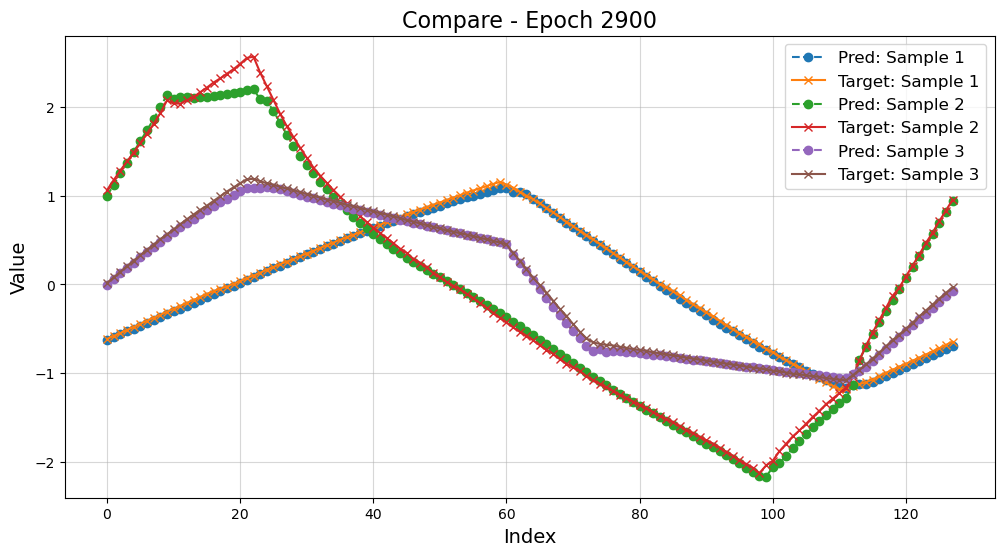

Epoch 2901, Train Loss: 0.002849, Validation Loss: 0.002728
Epoch 2902, Train Loss: 0.002749, Validation Loss: 0.002763
Epoch 2903, Train Loss: 0.002882, Validation Loss: 0.002677
Epoch 2904, Train Loss: 0.002693, Validation Loss: 0.002708
Epoch 2905, Train Loss: 0.002703, Validation Loss: 0.003241
Epoch 2906, Train Loss: 0.002784, Validation Loss: 0.002671
Epoch 2907, Train Loss: 0.002690, Validation Loss: 0.002612
Saving model at epoch 2907 with validation loss 0.002612...
Epoch 2908, Train Loss: 0.002634, Validation Loss: 0.002705
Epoch 2909, Train Loss: 0.002657, Validation Loss: 0.002646
Epoch 2910, Train Loss: 0.002741, Validation Loss: 0.002684
Epoch 2911, Train Loss: 0.002621, Validation Loss: 0.002755
Epoch 2912, Train Loss: 0.002722, Validation Loss: 0.002809
Epoch 2913, Train Loss: 0.002836, Validation Loss: 0.002936
Epoch 2914, Train Loss: 0.002791, Validation Loss: 0.002704
Epoch 2915, Train Loss: 0.002779, Validation Loss: 0.003058
Epoch 2916, Train Loss: 0.002800, Valida

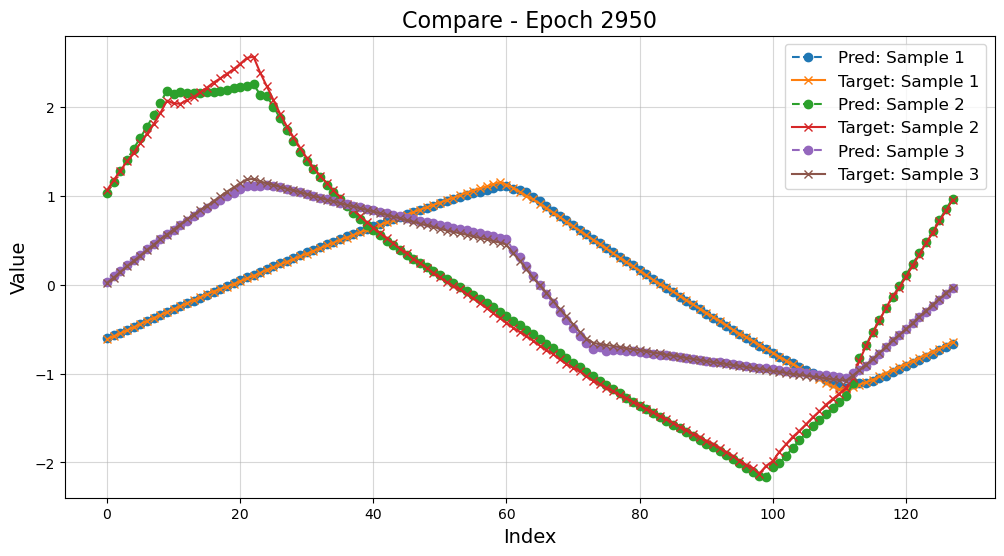

Epoch 2951, Train Loss: 0.002669, Validation Loss: 0.002621
Epoch 2952, Train Loss: 0.002641, Validation Loss: 0.002692
Epoch 2953, Train Loss: 0.002694, Validation Loss: 0.002858
Epoch 2954, Train Loss: 0.002720, Validation Loss: 0.002682
Epoch 2955, Train Loss: 0.002642, Validation Loss: 0.002735
Epoch 2956, Train Loss: 0.002752, Validation Loss: 0.002739
Epoch 2957, Train Loss: 0.002703, Validation Loss: 0.002697
Epoch 2958, Train Loss: 0.002753, Validation Loss: 0.002790
Epoch 2959, Train Loss: 0.002986, Validation Loss: 0.003546
Epoch 2960, Train Loss: 0.003107, Validation Loss: 0.003304
Epoch 2961, Train Loss: 0.003014, Validation Loss: 0.002670
Epoch 2962, Train Loss: 0.002726, Validation Loss: 0.002988
Epoch 2963, Train Loss: 0.002850, Validation Loss: 0.003058
Epoch 2964, Train Loss: 0.002965, Validation Loss: 0.003073
Epoch 2965, Train Loss: 0.002849, Validation Loss: 0.002941
Epoch 2966, Train Loss: 0.003043, Validation Loss: 0.002664
Epoch 2967, Train Loss: 0.002929, Valida

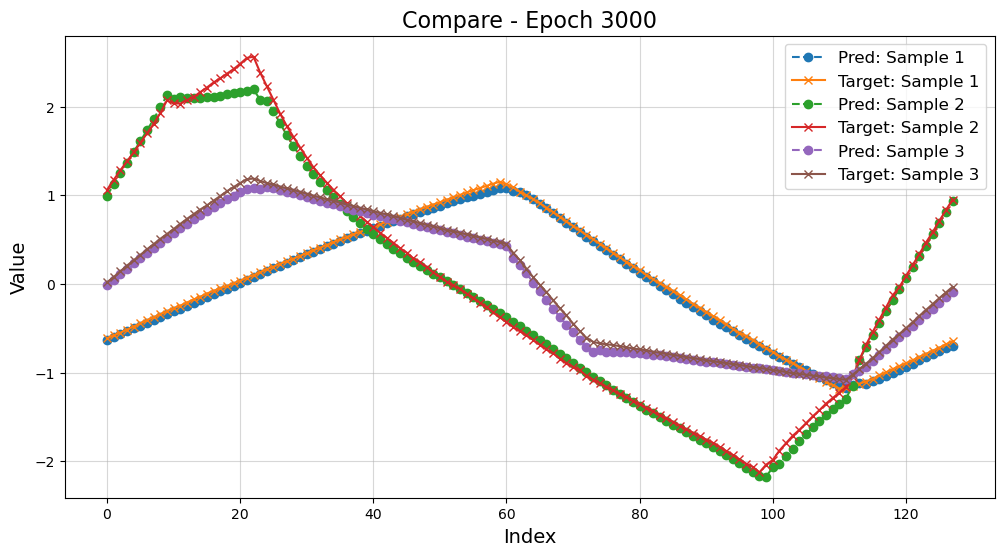

Training complete. Best model saved at ./Model/Material E.pt.


In [20]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv = load_dataset(material)
    norm = normsDict[material]

    train_loader, valid_loader = get_dataloader(data_B, data_F, data_T, data_H,
                                                data_Pcv, norm)

    train_model(train_loader, valid_loader)